<div id="toc"> </div>

# Import lots of stuff

In [30]:
import sys
sys.path.append('../')

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import math
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textacy
import textacy.io
import seaborn as sns
from utils.nlp_utils import lemmatize_doc
from nltk import Tree
from sklearn import manifold
import scipy.spatial.distance as distance

#from nltk import bigrams
from collections import Counter
#from pycorenlp import StanfordCoreNLP

pd.set_option('display.max_rows', 500)

Use spacy

In [82]:
import spacy
from spacy.lang.en import English
from spacy.attrs import POS
nlp = spacy.load('en_core_web_lg')

# Preprocess data for analyses

In [5]:
version_to_use = 'tangramsSequential_collapsed'

## Import annotated file & tag

In [83]:
d_raw = pd.read_csv('../data/{}.csv'.format(version_to_use))#.rename(index=str, columns={"contents": "text"})
d_raw['text'] = [nlp(text) for text in d_raw['contents']]

## Run spellchecker (using conservative vectors)

In [7]:
from utils import nlp_utils as utils
conservative_vectors = spacy.load('en_core_web_sm')

In [8]:
print(len(conservative_vectors.vocab))

476


In [178]:
utils.building_spell_correction_dictionary(
    d_raw.query('taskVersion == "cued"'), 
    conservative_vectors.vocab, 
    []
)

## Get list of all game ids

In [84]:
d = d_raw.copy()

In [85]:
d_raw.columns

Index(['gameid', 'trialNum', 'repetitionNum', 'intendedName', 'contents',
       'numRawWords', 'correct', 'text'],
      dtype='object')

In [86]:
gameidList = pd.unique(d.gameid.ravel()).tolist()
print(gameidList[0:5])
print(len(gameidList))

['0057-414228f8-c268-40d6-9349-b35df4f080d9', '0349-951c1418-40e9-48b3-8290-7ed4461f4d54', '0413-e4a76b36-4367-4e30-abf9-93e823913630', '0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', '0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7']
83


## Get list of all tangram names

In [12]:
tangramList = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
print(tangramList)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']


# What are most common words & phrases to reduce? 

Strangely, spacy has no n-gram function, so we use textacy, a convenience wrapper around spacy

In [19]:
d['doc'] = [textacy.Doc(textacy.preprocess_text(row, lowercase = True), lang='en_core_web_md') for row in d['contents']]

In [23]:
d['unigrams'] = [list(doc.to_terms_list(ngrams=1, as_strings=True, filter_stops = False, named_entities = False)) for doc in d['doc']]

d['bigrams'] = [list(doc.to_terms_list(ngrams=2, as_strings=True, filter_stops = False, named_entities = False)) for doc in d['doc']]

d['trigrams'] = [list(doc.to_terms_list(ngrams=3, as_strings=True, filter_stops = False, named_entities = False)) for doc in d['doc']]

In [24]:
d.head()

gameid  trialNum  repetitionNum  \
0  0057-414228f8-c268-40d6-9349-b35df4f080d9         1              1   
1  0057-414228f8-c268-40d6-9349-b35df4f080d9         2              1   
2  0057-414228f8-c268-40d6-9349-b35df4f080d9         3              1   
3  0057-414228f8-c268-40d6-9349-b35df4f080d9         4              1   
4  0057-414228f8-c268-40d6-9349-b35df4f080d9         5              1   

  intendedName                                           contents  \
0            B  looking for a diamond at the top, triangle poi...   
1            G                         this one looks like a seal   
2            K  this one looks like a small dog balancing a ba...   
3            A  this looks like one of the spy vs spy guys loo...   
4            J  this is a diamond on top of what looks like a ...   

   numRawWords  correct                                               text  \
0           47        1  (looking, for, a, diamond, at, the, top, ,, tr...   
1            6        0                  (this, one, looks, like, a, seal)   
2           13        0  (this, one, looks, like, a, small, dog, balanc...   
3           21        1  (this, looks, like, one, of, the, spy, vs, spy...   
4           20        1  (this, is, a, diamond, on, top, of, what, look...   

                                                 doc  \
0  (looking, for, a, diamond, at, the, top, ,, tr...   
1                  (this, one, looks, like, a, seal)   
2  (this, one, looks, like, a, small, dog, balanc...   
3  (this, looks, like, one, of, the, spy, vs, spy...   
4  (this, is, a, diamond, on, top, of, what, look...   

                                            unigrams  \
0  [look, for, a, diamond, at, the, top, triangle...   
1                   [this, one, look, like, a, seal]   
2  [this, one, look, like, a, small, dog, balance...   
3  [this, look, like, one, of, the, spy, vs, spy,...   
4  [this, be, a, diamond, on, top, of, what, look...   

                                             bigrams  \
0  [look for, for a, a diamond, diamond at, at th...   
1    [this one, one look, look like, like a, a seal]   
2  [this one, one look, look like, like a, a smal...   
3  [this look, look like, like one, one of, of th...   
4  [this be, be a, a diamond, diamond on, on top,...   

                                            trigrams  
0  [look for a, for a diamond, a diamond at, diam...  
1  [this one look, one look like, look like a, li...  
2  [this one look, one look like, look like a, li...  
3  [this look like, look like one, like one of, o...  
4  [this be a, be a diamond, a diamond on, diamon...

In [25]:
def getCounts(countType, df, gameid, repetitionNum, tangram = None) :
    roundCond = 'repetitionNum == ' + repetitionNum
    gameidCond = 'gameid == "' + gameid + '"'
    if(tangram is not None) :
        tangramCond = 'tangramRef == "' + tangram + '"'
        cond = " and ".join((roundCond, gameidCond, tangramCond))
    else :
        cond = " and ".join((roundCond, gameidCond))
    relevantRow = df.query(cond)
    return Counter([item for sublist in relevantRow[countType]
                    for item in sublist])

for countType in ['unigrams', 'bigrams', 'trigrams'] :
    countDict = Counter([item for sublist in d[countType]
                         for item in sublist])
    wordList = [v for (v,count) in countDict.items() if count > 20]

    with open('outputs/' + countType + 'Counts.csv', 'w') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(['gameid', 'repetitionNum', 'word', 'count'])
        for gameid in gameidList:  
            for repetitionNum in ['1', '2', '3', '4', '5', '6'] :
                counts = getCounts(countType, d, gameid, repetitionNum)
                for word in wordList :
                    writer.writerow([gameid, repetitionNum, word, counts[word]])

# Extract parts of speech

## Get counts for each POS label

In [89]:
tag_dict = {}
for doc in d['text'] :
    for w in doc :
        if w.pos not in tag_dict :
                tag_dict[w.pos_] = w.pos
d['posCounts'] = [doc.count_by(POS) for doc in d['text']]
print(tag_dict)
for posStr in ["NOUN", "DET", "PRON", "VERB", "ADJ", "CCONJ", "ADP", 'ADV'] :
    key_id = tag_dict[posStr]
    d[posStr + 'count'] = [counts[key_id] if key_id in counts else 0 for counts in d['posCounts']]

{'VERB': 100, 'ADP': 85, 'DET': 90, 'NOUN': 92, 'PUNCT': 97, 'ADJ': 84, 'ADV': 86, 'CCONJ': 89, 'NUM': 93, 'PRON': 95, 'SYM': 99, 'PART': 94, 'INTJ': 91, 'PROPN': 96, 'X': 101, 'SPACE': 103, 'AUX': 87}


In [90]:
d['tokens'] = [[token.text for token in l if not token.is_punct] for l in d['text']]
d['lemmas'] = [lemmatize_doc(text) for text in d['text']]
d['pos'] = [[token.pos_ for token in l if not token.is_punct] for l in d['text']]
d['noun_chunks'] = [list(l.noun_chunks) for l in d['text']]
d['numWords'] = [len([token for token in l if not token.is_punct]) for l in d['text']]

## Export to csv for plotting in R

In [29]:
(d.drop(["tokens", 'posCounts', 'text', 'numRawWords'], 1)
 .to_csv("./outputs/posTagged_{}.csv".format(version_to_use), index = False))

# syntactic analyses

look at which words are dropped on each round and whether they are more closely related to one another than expected under null model

In [87]:
import networkx as nx

def make_dep_graph(text) :
    # Load spacy's dependency tree into a networkx graph
    edges = []
    for token in text:
        for child in token.children:
            edges.append(('{0}-{1}'.format(token.lower_,token.i),
                          '{0}-{1}'.format(child.lower_,child.i)))

    return nx.Graph(edges)


def get_shortest_dependency_path (graph, word1, word2) :
    # https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.shortest_paths.html
    return nx.shortest_path_length(graph, source=word1, target=word2)

def flatten(list) :
    return [x for y in list for x in y]

In [120]:
np.random.choice(d.iloc[0]['lemmas'], 2, replace=False)

array(['to', 'triangle'], dtype='<U10')

In [134]:
from itertools import combinations


def get_mean_dependency_lengths(null = False) :
    true_dependency_lengths = []
    for name, df in d.groupby(['gameid', 'intendedName']) :
        print(name)
        df['next_lemmas'] = df['lemmas'].shift(-1)
        for _, row in df.iloc[0:-1].iterrows() :
            # handle case where we parse single message into multiple 'sentences'
            for i, sent in enumerate(row['text'].sents):
                graph = make_dep_graph(sent)
                dropped_words = ['{}-{}'.format(token.lower_,token.i) for token in sent
                                 if token.lemma_ not in row['next_lemmas'] and not token.is_punct]
                # for null model, we randomly sample words instead of using the real dropped ones
                if null : 
                    num_words_dropped = len(dropped_words)
                    random_words = np.random.choice([token.lemma_ for token in sent], 
                                                    num_words_dropped, replace=False)
                    dropped_words = ['{}-{}'.format(token.lower_,token.i) for token in sent
                                     if token.lemma_ in random_words]
                for word1, word2 in combinations(dropped_words, 2) :
                    try:
                        dep_length = get_shortest_dependency_path(graph, word1,word2) 
                        true_dependency_lengths.append(dep_length)
                    except :
                        print(dropped_words)
                        print(word1, word2)
                        print(nx.edges(graph))
                        nx.draw(graph)
                        plt.show()
    return np.array(true_dependency_lengths).mean()
true = get_mean_dependency_lengths(null = False)
print(true)
null = [get_mean_dependency_lengths(null = True) for i in range(1)]


('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')


/home/rxdh/miniconda3/envs/conventions/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'G')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'H')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'I')
('0349-951c1418-40e9-48b3-8290-

('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'J')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'K')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'L')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'A')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'B')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'C')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'D')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'E')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'F')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'G')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'H')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'I')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'J')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'K')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'L')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-

('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'E')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'F')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'G')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'H')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'I')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'J')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'K')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'L')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'A')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'B')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'C')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'D')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'E')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'F')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'G')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'H')
('4803-a27d2cc6-e504-4f67-8216-

('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'E')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'F')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'G')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'H')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'I')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'J')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'K')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'L')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'A')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'B')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'C')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'D')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'E')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'F')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'G')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'H')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'I')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'J')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'K')
('6335-f2ee42fb-60a5-4238-9bfc-

('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'B')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'C')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'D')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'E')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'F')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'G')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'H')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'I')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'J')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'K')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'L')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'A')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'B')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'C')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'D')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'E')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'F')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'G')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'H')
('8505-2fa3d6f9-8e28-49ed-8cd1-

('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'G')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'H')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'I')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'J')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'K')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'L')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'A')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'B')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'C')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'D')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'E')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'F')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'G')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'H')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'I')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'J')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'K')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'L')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'A')
('9567-370cab8f-7744-4910-8e41-

('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'E')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'F')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'G')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'H')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'I')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'J')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'K')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'L')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'A')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'B')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'C')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'D')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'E')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'F')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'G')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'H')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'I')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'J')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'K')
('1624-fe1e73c3-3feb-4949-8e71-

('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'I')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'J')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'K')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'L')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'A')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'B')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'C')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'D')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'E')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'F')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'G')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'H')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'I')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'J')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'K')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'L')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'A')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'B')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'C')
('4676-a65ba686-b220-4f71-91d6-

('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'B')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'C')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'D')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'E')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'F')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'G')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'H')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'I')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'J')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'K')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'L')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'A')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'B')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'C')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'D')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'E')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'F')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'G')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'H')
('5774-0e16513f-9938-4b1e-a647-

('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'E')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'F')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'G')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'H')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'I')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'J')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'K')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'L')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'A')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'B')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'C')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'D')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'E')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'F')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'G')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'H')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'I')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'J')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'K')
('7229-0a7402b0-329e-4b26-bc3a-

('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'L')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'A')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'B')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'C')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'D')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'E')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'F')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'G')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'H')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'I')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'J')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'K')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'L')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'A')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'B')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'C')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'D')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'E')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'F')
('9214-a3ed3b49-fe0c-4c41-b40f-

('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'K')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'L')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'A')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'B')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'C')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'D')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'E')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'F')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'G')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'H')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'I')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'J')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'K')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'L')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'A')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'B')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'C')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'D')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'E')
('1624-fe1e73c3-3feb-4949-8e71-

('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'B')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'C')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'D')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'E')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'F')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'G')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'H')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'I')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'J')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'K')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'L')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'A')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'B')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'C')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'D')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'E')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'F')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'G')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'H')
('4505-8cf1d946-db8a-413a-93bd-

('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'K')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'L')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'A')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'B')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'C')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'D')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'E')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'F')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'G')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'H')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'I')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'J')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'K')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'L')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'A')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'B')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'C')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'D')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'E')
('5792-f5aa5cf6-b3d0-4444-8442-

('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'B')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'C')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'D')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'E')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'F')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'G')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'H')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'I')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'J')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'K')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'L')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'A')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'B')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'C')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'D')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'E')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'F')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'G')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'H')
('7229-0a7402b0-329e-4b26-bc3a-

('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'J')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'K')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'L')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'A')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'B')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'C')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'D')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'E')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'F')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'G')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'H')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'I')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'J')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'K')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'L')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'A')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'B')
('9471-f19badf8-f934-48be-af51-

('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'D')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'E')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'F')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'G')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'H')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'I')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'J')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'K')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'L')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'A')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'B')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'C')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'D')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'E')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'F')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'G')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'H')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'I')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'J')
('1526-db8d7e61-c668-4fe2-9119-

('4513-c541e940-73fd-46b6-b19c-221458a22970', 'J')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'K')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'L')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'A')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'B')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'C')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'D')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'E')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'F')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'G')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'H')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'I')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'J')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'K')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'L')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'A')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-

('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'G')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'H')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'I')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'J')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'K')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'L')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'A')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'B')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'C')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'D')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'E')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'F')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'G')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'H')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'I')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'J')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'K')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'L')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'A')
('6335-f2ee42fb-60a5-4238-9bfc-

('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'I')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'J')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'K')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'L')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'A')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'B')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'C')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'D')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'E')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'F')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'G')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'H')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'I')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'J')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'K')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'L')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'A')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'B')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'C')
('8654-d24d0e84-d1d0-455c-8f51-

('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'G')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'H')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'I')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'J')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'K')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'L')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'A')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'B')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'C')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'D')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'E')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'F')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'G')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'H')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'I')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'J')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'K')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'L')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'A')
('5693-668d2b0f-d15b-4769-acdf-

('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'K')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'L')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'A')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'B')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'C')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'D')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'E')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'F')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'G')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'H')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'I')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'J')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'K')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'L')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'A')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'B')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'C')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'D')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'E')
('7229-0a7402b0-329e-4b26-bc3a-

('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'I')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'J')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'K')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'L')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'A')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'C')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'D')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'E')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'F')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'G')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'J')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'K')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'L')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'A')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'B')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'C')
('9286-508b20ce-1cbb-409f-bd5a-

('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'K')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'L')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'A')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'B')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'C')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'D')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'E')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'F')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'G')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'H')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'I')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'J')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'K')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'L')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-

('5032-f97819b4-cbef-4293-9d27-81134172edac', 'G')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'H')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'I')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'J')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'K')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'L')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'A')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'B')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'C')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'D')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'E')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'F')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'G')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'H')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'I')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'J')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'K')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'L')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'A')
('5108-ab2d0b72-034a-4f00-991a-

('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'K')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'L')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'A')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'B')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'C')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'D')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'E')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'F')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'G')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'H')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'I')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'J')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'K')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'L')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'A')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'B')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'C')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'D')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'E')
('7229-0a7402b0-329e-4b26-bc3a-

('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'C')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'D')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'E')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'F')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'G')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'J')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'K')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'L')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'A')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'B')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'C')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'D')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'E')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'F')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'G')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'H')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'I')
('8806-7b0fde86-a7ed-4821-9482-

('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'C')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'D')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'E')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'F')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'G')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'H')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'I')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'J')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'K')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'L')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'A')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'B')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'C')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'D')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'E')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'F')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'G')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'H')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'I')
('1670-7a1fc24b-6599-4efb-8a98-

('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'E')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'F')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'G')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'H')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'I')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'J')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'K')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'L')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'A')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'B')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'C')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'D')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'E')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'F')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'G')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'H')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'I')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'J')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'K')
('5032-f97819b4-cbef-4293-9d27-

('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'J')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'K')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'L')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'A')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'B')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'C')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'D')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'E')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'F')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'G')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'H')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'I')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'J')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'K')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'L')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'A')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'B')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'C')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'D')
('7229-0a7402b0-329e-4b26-bc3a-

('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'G')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'H')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'I')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'J')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'K')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'L')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'A')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'B')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'C')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'D')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'E')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'F')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'G')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'J')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'K')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'L')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'A')
('8806-7b0fde86-a7ed-4821-9482-

('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'F')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'G')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'H')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'I')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'J')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'K')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'L')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'A')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'B')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'C')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'D')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'E')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'F')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'G')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'H')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'I')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'J')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'K')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'L')
('2403-abcbe4e3-634c-40ec-89f8-

('4513-c541e940-73fd-46b6-b19c-221458a22970', 'H')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'I')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'J')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'K')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'L')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'A')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'B')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'C')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'D')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'E')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'F')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'G')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'H')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'I')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'J')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'K')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'L')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'A')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-

('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'F')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'G')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'H')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'I')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'J')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'K')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'L')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'A')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'B')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'C')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'D')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'E')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'F')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'G')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'H')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'I')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'J')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'K')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'L')
('5851-2c495782-8cef-496e-abba-

('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'D')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'E')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'F')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'G')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'H')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'I')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'J')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'K')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'L')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'A')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'B')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'C')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'D')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'E')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'F')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'G')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'H')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'I')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'J')
('8654-d24d0e84-d1d0-455c-8f51-

('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'K')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'L')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'A')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'B')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'C')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'D')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'E')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'F')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'G')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'H')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'I')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'J')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'K')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'L')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'A')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'B')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'C')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'D')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'E')
('1526-db8d7e61-c668-4fe2-9119-

('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'C')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'D')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'E')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'F')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'G')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'H')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'I')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'J')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'K')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'L')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'A')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'B')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'C')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'D')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'E')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'F')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'G')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'H')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'I')
('4076-4cf65365-3773-4e94-abc7-

('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'D')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'E')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'F')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'G')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'H')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'I')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'J')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'K')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'L')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'A')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'B')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'C')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'D')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'E')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'F')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'G')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'H')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'I')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'J')
('5192-8023d95b-29c5-49aa-a245-

('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'D')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'E')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'F')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'G')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'H')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'I')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'J')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'K')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'L')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'A')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'B')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'C')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'D')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'E')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'F')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'G')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'H')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'I')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'J')
('7171-cf9d40d1-2a66-4c80-8db6-

('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'H')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'I')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'J')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'K')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'L')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'A')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'B')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'C')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'D')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'E')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'F')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'G')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'H')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'I')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'J')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'K')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'L')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'A')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-

('0723-9b842133-a121-4b53-9c37-784e6023e022', 'J')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'K')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'L')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'A')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'B')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'C')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'D')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'E')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'F')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'G')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'H')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'I')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'J')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'K')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'L')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'A')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'B')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'C')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'D')
('1202-a64916b2-49d2-4ca4-bd76-

('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'A')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'E')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'F')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'G')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'H')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'I')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'J')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'K')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'L')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'A')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'B')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'C')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'D')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'E')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'F')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'G')
('4803-a27d2cc6-e504-4f67-8216-

('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'B')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'C')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'D')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'E')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'F')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'G')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'H')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'I')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'J')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'K')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'L')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'A')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'B')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'C')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'D')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'E')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'F')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'G')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'H')
('6402-3db6c45b-0b53-4906-b5cf-

('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'L')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'A')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'B')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'C')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'D')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'E')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'F')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'G')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'H')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'I')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'J')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'K')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'L')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'A')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'B')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'C')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'D')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'E')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'F')
('8659-24ecfb2c-6a3d-4607-ab5e-

('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'G')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'H')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'I')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'J')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'K')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'L')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'A')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'B')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'C')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'D')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'E')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'F')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'G')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'H')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'I')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'J')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'K')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'L')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'A')
('1598-17655913-31a4-4ca6-b86c-

('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'J')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'K')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'L')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'A')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'B')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'C')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'D')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'E')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'F')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'G')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'H')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'I')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'J')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'K')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'L')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'A')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'B')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'C')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'D')
('4505-8cf1d946-db8a-413a-93bd-

('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'B')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'C')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'D')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'E')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'F')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'G')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'H')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'I')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'J')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'K')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'L')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'A')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'B')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'C')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'D')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'E')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'F')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'G')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'H')
('5851-2c495782-8cef-496e-abba-

('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'J')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'K')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'L')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'A')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'B')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'C')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'D')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'E')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'F')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'G')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'H')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'I')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'J')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'K')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'L')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'A')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'B')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'C')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'D')
('8717-5275ed0c-7fcc-4114-8327-

('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'G')
('0349-951c1418-40e9-48b3-8290-

('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'F')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'G')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'H')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'I')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'J')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'K')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'L')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-

('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'E')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'F')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'G')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'H')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'I')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'J')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'K')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'L')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'A')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'B')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'C')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'D')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'E')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'F')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'G')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'H')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'I')
('4803-a27d2cc6-e504-4f67-8216-

('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'L')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'A')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'B')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'C')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'D')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'E')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'F')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'G')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'H')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'I')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'J')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'K')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'L')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'A')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'B')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'C')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'D')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'E')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'F')
('6402-3db6c45b-0b53-4906-b5cf-

('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'C')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'D')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'E')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'F')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'G')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'H')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'I')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'J')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'K')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'L')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'A')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'C')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'D')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'E')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'F')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'G')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-

('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'L')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'A')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'B')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'C')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'D')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'E')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'F')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'G')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'H')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'I')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'J')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'K')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'L')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'A')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'B')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'C')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'D')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'E')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'F')
('1242-e6fcc1c9-ab33-44c7-b31c-

('4824-58d5c545-a718-4653-89db-4be922da59d7', 'F')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'G')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'H')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'I')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'J')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'K')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'L')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'A')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'B')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'C')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'D')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'E')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'F')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'G')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'H')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'I')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'J')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'K')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'L')
('4853-e6b0e457-f035-428e-be9a-

('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'G')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'H')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'I')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'J')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'K')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'L')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'A')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'B')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'C')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'D')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'E')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'F')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'G')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'H')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'I')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'J')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'K')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'L')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'A')
('6524-a23c203d-4591-4fa2-aabd-

('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'F')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'G')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'H')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'I')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'J')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'K')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'L')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'A')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'B')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'C')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'D')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'E')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'F')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'G')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'H')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'I')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'J')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'K')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'L')
('8659-24ecfb2c-6a3d-4607-ab5e-

('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'G')
('0349-951c1418-40e9-48b3-8290-

('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'G')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'H')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'I')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'J')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'K')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'L')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-

('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'J')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'K')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'L')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'A')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'B')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'C')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'D')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'E')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'F')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'G')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'H')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'I')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'J')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'K')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'L')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'A')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'B')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'C')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'D')
('4824-58d5c545-a718-4653-89db-

('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'L')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'A')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'B')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'C')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'D')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'E')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'F')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'G')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'H')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'I')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'J')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'K')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'L')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'A')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'B')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'C')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'D')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'E')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'F')
('6413-5ebde90e-fb15-4c9b-a6f9-

('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'H')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'I')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'J')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'K')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'L')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'A')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'B')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'C')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'D')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'E')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'F')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'G')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'H')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'I')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'J')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'K')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'L')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'A')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'B')
('8654-d24d0e84-d1d0-455c-8f51-

('9559-04e2b195-6540-4711-9830-5178487fc07c', 'L')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'A')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'B')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'C')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'D')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'E')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'F')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'G')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'H')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'I')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'J')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'K')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'L')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'A')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'B')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'C')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'D')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'E')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'F')
('9684-5db90167-5d0b-40a4-9ec2-

('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'D')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'E')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'F')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'G')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'H')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'I')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'J')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'K')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'L')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'A')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'B')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'C')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'D')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'E')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'F')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'G')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'H')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'I')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'J')
('2223-ecc53ef3-7e9a-4776-b7c5-

('5032-f97819b4-cbef-4293-9d27-81134172edac', 'C')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'D')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'E')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'F')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'G')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'H')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'I')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'J')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'K')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'L')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'A')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'B')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'C')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'D')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'E')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'F')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'G')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'H')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'I')
('5100-ae37a906-ac5a-4cf2-b89a-

('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'L')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'A')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'B')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'C')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'D')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'E')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'F')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'G')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'H')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'I')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'J')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'K')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'L')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'A')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'B')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'C')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'D')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'E')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'F')
('7171-cf9d40d1-2a66-4c80-8db6-

('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'K')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'L')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'A')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'B')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'C')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'D')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'E')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'F')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'G')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'J')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'K')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'L')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'A')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'B')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'C')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'D')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'E')
('8806-7b0fde86-a7ed-4821-9482-

('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'A')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'B')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'C')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'D')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'E')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'F')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'G')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'H')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'I')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'J')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'K')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'L')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'A')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'B')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'C')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'D')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'E')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'F')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'G')
('0711-b03679d3-9904-4263-bd2f-

('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'L')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'A')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'B')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'C')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'D')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'E')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'F')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'G')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'H')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'I')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'J')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'K')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'L')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'A')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'B')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'C')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'D')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'E')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'F')
('4505-8cf1d946-db8a-413a-93bd-

('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'C')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'D')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'E')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'F')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'G')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'H')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'I')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'J')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'K')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'L')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'A')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'B')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'C')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'D')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'E')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'F')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'G')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'H')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'I')
('6064-6e0d77e9-b8e8-4a65-97d2-

('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'K')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'L')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'A')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'B')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'C')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'D')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'E')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'F')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'G')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'H')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'I')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'J')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'K')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'L')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'A')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'B')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'C')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'D')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'E')
('8654-d24d0e84-d1d0-455c-8f51-

('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'K')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'L')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-

('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'J')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'K')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'L')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-

('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'H')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'I')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'J')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'K')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'L')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'A')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'B')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'C')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'D')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'E')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'F')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'G')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'H')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'I')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'J')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'K')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'L')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'A')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'B')
('6254-50e82f4c-5a88-4a7a-a1f1-

('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'C')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'D')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'E')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'F')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'G')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'J')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'K')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'L')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'A')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'B')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'C')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'D')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'E')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'F')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'G')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'H')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'I')
('8806-7b0fde86-a7ed-4821-9482-

('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'L')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'A')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'B')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'C')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'D')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'E')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'F')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'G')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'H')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'I')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'J')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'K')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'L')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'A')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'B')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'C')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'D')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'E')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'F')
('0711-b03679d3-9904-4263-bd2f-

('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'E')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'F')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'G')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'H')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'I')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'J')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'K')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'L')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'A')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'B')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'C')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'D')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'E')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'F')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'G')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'H')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'I')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'J')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'K')
('4824-58d5c545-a718-4653-89db-

('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'G')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'H')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'I')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'J')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'K')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'L')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'A')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'B')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'C')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'D')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'E')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'F')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'G')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'H')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'I')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'J')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'K')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'L')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'A')
('6488-1c981017-2f98-48e2-88b2-

('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'I')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'J')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'K')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'L')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'A')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'B')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'C')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'D')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'E')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'F')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'G')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'H')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'I')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'J')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'K')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'L')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'A')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'B')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'C')
('9214-a3ed3b49-fe0c-4c41-b40f-

('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'C')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'D')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'E')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'F')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'G')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'H')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'I')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'J')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'K')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'L')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'A')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'B')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'C')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'D')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'E')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'F')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'G')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'H')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'I')
('1202-a64916b2-49d2-4ca4-bd76-

('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'I')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'J')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'K')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'L')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'A')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'B')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'C')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'D')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'E')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'F')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'G')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'H')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'I')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'J')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'K')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'L')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'A')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'B')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'C')
('5032-f97819b4-cbef-4293-9d27-

('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'F')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'G')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'H')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'I')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'J')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'K')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'L')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'A')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'B')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'C')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'D')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'E')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'F')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'G')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'H')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'I')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'J')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'K')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'L')
('6956-00137ff0-3569-4135-81ab-

('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'L')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'A')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'B')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'C')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'D')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'E')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'F')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'G')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'H')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'I')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'J')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'K')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'L')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'A')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'C')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'D')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'E')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'F')
('9275-8cd69f6d-2b0e-494b-8fea-

('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'E')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'F')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'G')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'H')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'I')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'J')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'K')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'L')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'A')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'B')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'C')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'D')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'E')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'F')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'G')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'H')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'I')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'J')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'K')
('1747-31c92e68-6900-4f75-b1d5-

('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'E')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'F')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'G')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'H')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'I')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'J')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'K')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'L')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'A')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'B')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'C')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'D')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'E')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'F')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'G')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'H')
('4803-a27d2cc6-e504-4f67-8216-

('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'G')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'H')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'I')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'J')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'K')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'L')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'A')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'B')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'C')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'D')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'E')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'F')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'G')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'H')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'I')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'J')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'K')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'L')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'A')
('6413-5ebde90e-fb15-4c9b-a6f9-

('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'A')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'B')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'C')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'D')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'E')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'F')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'G')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'H')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'I')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'J')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'K')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'L')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'A')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'B')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'C')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'D')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'E')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'F')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'G')
('8659-24ecfb2c-6a3d-4607-ab5e-

('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'G')
('0349-951c1418-40e9-48b3-8290-

('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'G')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'H')
('2535-a47c997d-4aac-43f5-adad-

('4824-58d5c545-a718-4653-89db-4be922da59d7', 'J')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'K')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'L')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'A')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'B')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'C')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'D')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'E')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'F')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'G')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'H')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'I')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'J')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'K')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'L')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'A')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'B')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'C')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'D')
('4853-e6b0e457-f035-428e-be9a-

('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'C')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'D')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'E')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'F')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'G')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'H')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'I')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'J')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'K')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'L')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'A')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'B')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'C')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'D')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'E')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'F')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'G')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'H')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'I')
('7547-22755035-a3a9-4044-aca1-

('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'C')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'D')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'E')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'F')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'G')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'H')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'I')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'J')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'K')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'L')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'A')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'C')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'D')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'E')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'F')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'G')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-

('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'F')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'G')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'H')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'I')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'J')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'K')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'L')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'A')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'B')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'C')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'D')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'E')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'F')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'G')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'H')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'I')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'J')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'K')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'L')
('1242-e6fcc1c9-ab33-44c7-b31c-

('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'F')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'G')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'H')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'I')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'J')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'K')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'L')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'A')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'B')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'C')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'D')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'E')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'F')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'G')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'H')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'I')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'J')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'K')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'L')
('4090-bf4b8726-1596-4231-84d9-

('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'K')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'L')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'A')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'B')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'C')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'D')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'E')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'F')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'G')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'H')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'I')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'J')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'K')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'L')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'A')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'B')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'C')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'D')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'E')
('5792-f5aa5cf6-b3d0-4444-8442-

('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'H')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'I')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'J')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'K')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'L')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'A')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'B')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'C')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'D')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'E')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'F')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'G')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'H')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'I')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'J')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'K')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'L')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'A')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'B')
('8505-2fa3d6f9-8e28-49ed-8cd1-

('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'C')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'D')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'E')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'F')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'G')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'H')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'I')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'J')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'K')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'L')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'A')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'B')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'C')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'D')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'E')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'F')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'G')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'H')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'I')
('9477-662e7f6d-0f2a-4041-a4e7-

('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'A')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'B')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'C')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'D')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'E')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'F')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'G')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'H')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'I')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'J')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'K')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'L')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'A')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'B')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'C')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'D')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'E')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'F')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'G')
('1670-7a1fc24b-6599-4efb-8a98-

('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'C')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'D')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'E')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'F')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'G')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'H')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'I')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'J')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'K')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'L')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'A')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'E')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'F')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'G')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'H')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'I')
('4729-d4a13957-3f36-496d-8eea-

('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'B')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'C')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'D')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'E')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'F')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'G')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'H')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'I')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'J')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'K')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'L')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'A')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'B')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'C')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'D')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'E')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'F')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'G')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'H')
('6402-3db6c45b-0b53-4906-b5cf-

('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'L')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'A')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'B')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'C')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'D')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'E')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'F')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'G')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'H')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'I')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'J')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'K')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'L')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'A')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'B')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'C')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'D')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'E')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'F')
('8656-2ce86ed6-891b-459e-b44f-

('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'G')
('0349-951c1418-40e9-48b3-8290-

('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'B')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'C')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'D')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'E')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'F')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'G')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'H')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'I')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'J')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'K')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'L')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'A')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'B')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'C')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'D')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'E')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'F')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'G')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'H')
('3321-5540179d-7955-4363-b9d2-

('5032-f97819b4-cbef-4293-9d27-81134172edac', 'A')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'B')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'C')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'D')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'E')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'F')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'G')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'H')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'I')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'J')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'K')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'L')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'A')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'B')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'C')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'D')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'E')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'F')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'G')
('5100-ae37a906-ac5a-4cf2-b89a-

('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'F')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'G')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'H')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'I')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'J')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'K')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'L')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'A')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'B')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'C')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'D')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'E')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'F')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'G')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'H')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'I')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'J')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'K')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'L')
('7194-9e2d0432-1fda-4f7d-8faa-

('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'C')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'D')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'E')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'F')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'G')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'J')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'K')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'L')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'A')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'B')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'C')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'D')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'E')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'F')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'G')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'H')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'I')
('8806-7b0fde86-a7ed-4821-9482-

('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'I')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'J')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'K')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'L')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'A')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'B')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'C')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'D')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'E')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'F')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'G')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'H')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'I')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'J')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'K')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'L')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'A')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'B')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'C')
('0785-68fedef2-3b2f-466f-a7c3-

('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'E')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'F')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'G')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'H')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'I')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'J')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'K')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'L')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'A')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'B')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'C')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'D')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'E')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'F')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'G')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'H')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'I')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'J')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'K')
('4011-501727ae-d5dc-405f-8450-

('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'C')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'D')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'E')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'F')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'G')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'H')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'I')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'J')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'K')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'L')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'A')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'B')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'C')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'D')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'E')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'F')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'G')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'H')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'I')
('5693-668d2b0f-d15b-4769-acdf-

('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'C')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'D')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'E')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'F')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'G')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'H')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'I')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'J')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'K')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'L')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'A')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'B')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'C')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'D')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'E')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'F')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'G')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'H')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'I')
('7391-0be22306-9b90-402c-82b0-

('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'K')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'L')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'A')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'B')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'C')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'D')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'E')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'F')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'G')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'H')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'I')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'J')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'K')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'L')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'A')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'B')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'C')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'D')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'E')
('9559-04e2b195-6540-4711-9830-

('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'D')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'E')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'F')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'G')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'H')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'I')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'J')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'K')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'L')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'A')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'B')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'C')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'D')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'E')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'F')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'G')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'H')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'I')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'J')
('1670-7a1fc24b-6599-4efb-8a98-

('4513-c541e940-73fd-46b6-b19c-221458a22970', 'L')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'A')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'B')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'C')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'D')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'E')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'F')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'G')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'H')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'I')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'J')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'K')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'L')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'A')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'E')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'F')
('4729-d4a13957-3f36-496d-8eea-

('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'E')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'F')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'G')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'H')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'I')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'J')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'K')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'L')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'A')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'B')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'C')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'D')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'E')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'F')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'G')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'H')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'I')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'J')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'K')
('6335-f2ee42fb-60a5-4238-9bfc-

('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'J')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'K')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'L')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'A')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'B')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'C')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'D')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'E')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'F')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'G')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'J')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'K')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'L')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'A')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'B')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'C')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'D')
('8806-7b0fde86-a7ed-4821-9482-

('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'H')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'I')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'J')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'K')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'L')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'A')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'B')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'C')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'D')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'E')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'F')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'G')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'H')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'I')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'J')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'K')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'L')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'A')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'B')
('0711-b03679d3-9904-4263-bd2f-

('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'I')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'J')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'K')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'L')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'A')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'B')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'C')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'D')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'E')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'F')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'G')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'H')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'I')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'J')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'K')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'L')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'A')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'B')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'C')
('3617-9ac86786-87e4-468d-bbd9-

('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'K')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'L')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'A')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'B')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'C')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'D')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'E')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'F')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'G')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'H')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'I')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'J')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'K')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'L')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'A')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'B')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'C')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'D')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'E')
('5154-e7f636b5-f787-4bef-be2b-

('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'I')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'J')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'K')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'L')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'A')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'B')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'C')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'D')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'E')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'F')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'G')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'H')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'I')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'J')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'K')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'L')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'A')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'B')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'C')
('7194-9e2d0432-1fda-4f7d-8faa-

('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'F')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'G')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'J')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'K')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'L')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'A')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'B')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'C')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'D')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'E')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'F')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'G')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'H')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'I')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'J')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'K')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'L')
('8915-5ba403bf-9d53-44e0-a5e3-

('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'G')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'H')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'I')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'J')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'K')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'L')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'A')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'B')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'C')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'D')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'E')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'F')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'G')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'H')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'I')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'J')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'K')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'L')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'A')
('0723-9b842133-a121-4b53-9c37-

('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'D')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'E')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'F')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'G')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'H')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'I')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'J')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'K')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'L')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'A')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'B')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'C')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'D')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'E')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'F')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'G')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'H')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'I')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'J')
('4045-c97cdcce-7538-408d-b8dd-

('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'A')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'B')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'C')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'D')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'E')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'F')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'G')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'H')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'I')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'J')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'K')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'L')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'A')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'B')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'C')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'D')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'E')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'F')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'G')
('5693-668d2b0f-d15b-4769-acdf-

('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'B')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'C')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'D')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'E')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'F')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'G')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'H')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'I')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'J')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'K')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'L')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'A')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'B')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'C')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'D')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'E')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'F')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'G')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'H')
('7484-32a69501-b5bc-4166-ac2b-

('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'C')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'D')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'E')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'F')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'G')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'J')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'K')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'L')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'A')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'B')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'C')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'D')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'E')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'F')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'G')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'H')
('9286-508b20ce-1cbb-409f-bd5a-

('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'C')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'D')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'E')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'F')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'G')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'H')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'I')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'J')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'K')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'L')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'A')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'B')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'C')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'D')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'E')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'F')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'G')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'H')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'I')
('1598-17655913-31a4-4ca6-b86c-

('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'I')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'J')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'K')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'L')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'A')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'B')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'C')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'D')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'E')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'F')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'G')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'H')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'I')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'J')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'K')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'L')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'A')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'B')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'C')
('4505-8cf1d946-db8a-413a-93bd-

('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'A')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'B')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'C')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'D')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'E')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'F')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'G')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'H')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'I')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'J')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'K')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'L')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'A')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'B')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'C')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'D')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'E')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'F')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'G')
('5851-2c495782-8cef-496e-abba-

('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'F')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'G')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'H')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'I')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'J')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'K')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'L')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'A')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'B')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'C')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'D')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'E')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'F')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'G')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'H')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'I')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'J')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'K')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'L')
('7391-0be22306-9b90-402c-82b0-

('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'H')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'I')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'J')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'K')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'L')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'A')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'B')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'C')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'D')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'E')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'F')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'G')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'H')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'I')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'J')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'K')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'L')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'A')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-

('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'B')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'C')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'D')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'E')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'F')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'G')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'H')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'I')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'J')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'K')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'L')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'A')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'B')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'C')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'D')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'E')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'F')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'G')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'H')
('1624-fe1e73c3-3feb-4949-8e71-

('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'L')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'A')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'B')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'C')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'D')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'E')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'F')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'G')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'H')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'I')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'J')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'K')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'L')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'A')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'B')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'C')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'D')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'E')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'F')
('4513-c541e940-73fd-46b6-b19c-

('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'F')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'G')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'H')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'I')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'J')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'K')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'L')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'A')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'B')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'C')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'D')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'E')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'F')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'G')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'H')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'I')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'J')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'K')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'L')
('6335-f2ee42fb-60a5-4238-9bfc-

('7642-536146ba-7c31-4590-832e-905c0126f60e', 'H')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'I')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'J')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'K')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'L')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'A')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'B')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'C')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'D')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'E')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'F')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'G')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'H')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'I')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'J')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'K')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'L')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'A')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'B')
('7971-85165980-35a3-4070-8ebf-

('9559-04e2b195-6540-4711-9830-5178487fc07c', 'H')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'I')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'J')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'K')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'L')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'A')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'B')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'C')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'D')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'E')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'F')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'G')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'H')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'I')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'J')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'K')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'L')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'A')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'B')
('9684-5db90167-5d0b-40a4-9ec2-

('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'G')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'H')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'I')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'J')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'K')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'L')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'A')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'B')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'C')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'D')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'E')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'F')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'G')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'H')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'I')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'J')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'K')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'L')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-

('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'A')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'E')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'F')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'G')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'H')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'I')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'J')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'K')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'L')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'A')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'B')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'C')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'D')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'E')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'F')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'G')
('4803-a27d2cc6-e504-4f67-8216-

('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'B')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'C')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'D')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'E')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'F')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'G')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'H')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'I')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'J')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'K')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'L')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'A')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'B')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'C')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'D')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'E')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'F')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'G')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'H')
('6064-6e0d77e9-b8e8-4a65-97d2-

('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'K')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'L')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'A')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'B')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'C')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'D')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'E')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'F')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'G')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'H')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'I')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'J')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'K')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'L')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'A')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'B')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'C')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'D')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'E')
('8553-87ac5b2f-ee64-443b-a3a9-

('9559-04e2b195-6540-4711-9830-5178487fc07c', 'A')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'B')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'C')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'D')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'E')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'F')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'G')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'H')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'I')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'J')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'K')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'L')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'A')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'B')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'C')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'D')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'E')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'F')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'G')
('9567-370cab8f-7744-4910-8e41-

('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'H')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'I')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'J')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'K')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'L')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'A')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'B')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'C')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'D')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'E')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'F')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'G')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'H')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'I')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'J')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'K')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'L')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'A')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'B')
('1624-fe1e73c3-3feb-4949-8e71-

('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'C')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'D')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'E')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'F')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'G')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'H')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'I')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'J')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'K')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'L')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'A')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'E')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'F')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'G')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'H')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'I')
('4729-d4a13957-3f36-496d-8eea-

('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'H')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'I')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'J')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'K')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'L')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'A')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'B')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'C')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'D')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'E')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'F')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'G')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'H')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'I')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'J')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'K')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'L')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'A')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'B')
('6413-5ebde90e-fb15-4c9b-a6f9-

('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'E')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'F')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'G')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'H')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'I')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'J')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'K')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'L')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'A')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'B')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'C')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'D')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'E')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'F')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'G')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'H')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'I')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'J')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'K')
('8553-87ac5b2f-ee64-443b-a3a9-

('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'G')
('0349-951c1418-40e9-48b3-8290-

('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'L')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-

('5032-f97819b4-cbef-4293-9d27-81134172edac', 'C')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'D')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'E')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'F')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'G')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'H')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'I')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'J')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'K')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'L')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'A')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'B')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'C')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'D')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'E')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'F')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'G')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'H')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'I')
('5100-ae37a906-ac5a-4cf2-b89a-

('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'F')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'G')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'H')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'I')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'J')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'K')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'L')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'A')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'B')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'C')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'D')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'E')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'F')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'G')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'H')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'I')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'J')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'K')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'L')
('7391-0be22306-9b90-402c-82b0-

('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'J')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'K')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'L')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'A')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'C')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'D')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'E')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'F')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'G')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'J')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'K')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'L')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'A')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'B')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'C')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'D')
('9286-508b20ce-1cbb-409f-bd5a-

('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'I')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'J')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'K')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'L')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'A')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'B')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'C')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'D')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'E')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'F')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'G')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'H')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'I')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'J')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'K')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'L')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'A')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'B')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'C')
('2223-ecc53ef3-7e9a-4776-b7c5-

('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'I')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'J')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'K')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'L')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'A')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'B')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'C')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'D')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'E')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'F')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'G')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'H')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'I')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'J')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'K')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'L')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'A')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'B')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'C')
('5032-f97819b4-cbef-4293-9d27-

('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'F')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'G')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'H')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'I')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'J')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'K')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'L')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'A')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'B')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'C')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'D')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'E')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'F')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'G')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'H')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'I')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'J')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'K')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'L')
('7391-0be22306-9b90-402c-82b0-

('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'C')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'D')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'E')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'F')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'G')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'J')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'K')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'L')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'A')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'B')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'C')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'D')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'E')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'F')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'G')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'H')
('9286-508b20ce-1cbb-409f-bd5a-

('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'L')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-

('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'C')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'D')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'E')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'F')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'G')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'H')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'I')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'J')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'K')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'L')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'A')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'B')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'C')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'D')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'E')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'F')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'G')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'H')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'I')
('5693-668d2b0f-d15b-4769-acdf-

('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'I')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'J')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'K')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'L')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'A')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'B')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'C')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'D')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'E')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'F')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'G')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'H')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'I')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'J')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'K')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'L')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'A')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'B')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'C')
('7171-cf9d40d1-2a66-4c80-8db6-

('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'G')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'J')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'K')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'L')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'A')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'B')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'C')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'D')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'E')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'F')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'G')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'H')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'I')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'J')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'K')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'L')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'A')
('9471-f19badf8-f934-48be-af51-

('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'L')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-

('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'B')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'C')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'D')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'E')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'F')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'G')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'H')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'I')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'J')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'K')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'L')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'A')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'B')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'C')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'D')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'E')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'F')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'G')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'H')
('5154-e7f636b5-f787-4bef-be2b-

('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'C')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'D')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'E')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'F')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'G')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'H')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'I')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'J')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'K')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'L')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'A')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'B')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'C')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'D')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'E')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'F')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'G')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'H')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'I')
('6524-a23c203d-4591-4fa2-aabd-

('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'C')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'D')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'E')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'F')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'G')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'H')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'I')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'J')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'K')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'L')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'A')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'B')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'C')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'D')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'E')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'F')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'G')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-

('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'H')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'I')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'J')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'K')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'L')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'A')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'B')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'C')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'D')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'E')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'F')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'G')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'H')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'I')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'J')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'K')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'L')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'A')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'B')
('1747-31c92e68-6900-4f75-b1d5-

('4513-c541e940-73fd-46b6-b19c-221458a22970', 'F')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'G')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'H')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'I')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'J')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'K')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'L')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'A')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'B')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'C')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'D')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'E')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'F')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'G')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'H')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'I')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'J')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'K')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'L')
('4729-d4a13957-3f36-496d-8eea-

('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'C')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'D')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'E')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'F')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'G')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'H')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'I')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'J')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'K')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'L')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'A')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'B')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'C')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'D')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'E')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'F')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'G')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'H')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'I')
('6064-6e0d77e9-b8e8-4a65-97d2-

('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'K')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'L')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'A')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'B')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'C')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'D')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'E')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'F')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'G')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'H')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'I')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'J')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'K')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'L')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'A')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'B')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'C')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'D')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'E')
('8654-d24d0e84-d1d0-455c-8f51-

('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'B')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'C')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'D')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'E')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'F')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'G')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'H')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'I')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'J')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'K')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'L')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'A')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'B')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'C')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'D')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'E')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'F')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'G')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'H')
('0711-b03679d3-9904-4263-bd2f-

('4513-c541e940-73fd-46b6-b19c-221458a22970', 'K')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'L')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'A')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'B')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'C')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'D')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'E')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'F')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'G')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'H')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'I')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'J')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'K')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'L')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'A')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'E')
('4729-d4a13957-3f36-496d-8eea-

('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'E')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'F')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'G')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'H')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'I')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'J')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'K')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'L')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'A')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'B')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'C')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'D')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'E')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'F')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'G')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'H')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'I')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'J')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'K')
('6064-6e0d77e9-b8e8-4a65-97d2-

('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'L')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'A')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'B')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'C')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'D')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'E')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'F')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'G')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'H')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'I')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'J')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'K')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'L')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'A')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'B')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'C')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'D')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'E')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'F')
('8717-5275ed0c-7fcc-4114-8327-

('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'G')
('0349-951c1418-40e9-48b3-8290-

('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'L')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'A')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'B')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'C')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'D')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'E')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'F')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'G')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'H')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'I')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'J')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'K')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'L')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-

('4513-c541e940-73fd-46b6-b19c-221458a22970', 'D')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'E')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'F')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'G')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'H')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'I')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'J')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'K')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'L')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'A')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'B')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'C')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'D')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'E')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'F')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'G')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'H')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'I')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'J')
('4676-a65ba686-b220-4f71-91d6-

('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'B')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'C')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'D')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'E')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'F')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'G')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'H')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'I')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'J')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'K')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'L')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'A')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'B')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'C')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'D')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'E')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'F')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'G')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'H')
('6064-6e0d77e9-b8e8-4a65-97d2-

('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'C')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'D')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'E')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'F')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'G')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'J')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'K')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'L')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'A')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'B')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'C')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'D')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'E')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'F')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'G')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'H')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'I')
('8806-7b0fde86-a7ed-4821-9482-

('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'J')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'K')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'L')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'A')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'B')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'C')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'D')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'E')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'F')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'G')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'H')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'I')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'J')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'K')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'L')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'A')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'B')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'C')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'D')
('0461-f522f8f4-37dc-4bb0-89bf-

('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'G')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'H')
('2535-a47c997d-4aac-43f5-adad-

('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'L')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'A')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'B')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'C')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'D')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'E')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'F')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'G')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'H')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'I')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'J')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'K')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'L')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'A')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'B')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'C')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'D')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'E')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'F')
('6254-50e82f4c-5a88-4a7a-a1f1-

('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'J')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'K')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'L')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'A')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'B')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'C')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'D')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'E')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'F')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'G')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'H')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'I')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'J')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'K')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'L')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'A')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'B')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'C')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'D')
('8654-d24d0e84-d1d0-455c-8f51-

('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'K')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'L')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'A')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'B')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'C')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'D')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'E')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'F')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'G')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'H')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'I')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'J')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'K')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'L')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-

('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'I')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'J')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'K')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'L')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-

('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'F')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'G')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'H')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'I')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'J')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'K')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'L')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'A')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'B')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'C')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'D')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'E')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'F')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'G')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'H')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'I')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'J')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'K')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'L')
('4843-98b6ce35-ee60-474f-8281-

('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'I')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'J')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'K')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'L')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'A')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'B')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'C')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'D')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'E')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'F')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'G')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'H')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'I')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'J')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'K')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'L')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'A')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'B')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'C')
('7391-0be22306-9b90-402c-82b0-

('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'J')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'K')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'L')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'A')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'B')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'C')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'D')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'E')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'F')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'G')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'H')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'I')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'J')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'K')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'L')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'A')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'B')
('8915-5ba403bf-9d53-44e0-a5e3-

('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'G')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'H')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'I')
('2535-a47c997d-4aac-43f5-adad-

('5032-f97819b4-cbef-4293-9d27-81134172edac', 'G')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'H')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'I')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'J')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'K')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'L')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'A')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'B')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'C')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'D')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'E')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'F')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'G')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'H')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'I')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'J')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'K')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'L')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'A')
('5108-ab2d0b72-034a-4f00-991a-

('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'D')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'E')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'F')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'G')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'H')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'I')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'J')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'K')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'L')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'A')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'B')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'C')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'D')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'E')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'F')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'G')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'H')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'I')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'J')
('7194-9e2d0432-1fda-4f7d-8faa-

('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'G')
('0349-951c1418-40e9-48b3-8290-

('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'G')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'H')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'I')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'J')
('2535-a47c997d-4aac-43f5-adad-

('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'G')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'H')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'I')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'J')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'K')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'L')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'A')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'B')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'C')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'D')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'E')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'F')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'G')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'H')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'I')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'J')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'K')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'L')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'A')
('6413-5ebde90e-fb15-4c9b-a6f9-

('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'E')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'F')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'G')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'H')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'I')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'J')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'K')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'L')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'A')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'B')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'C')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'D')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'E')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'F')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'G')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'H')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'I')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'J')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'K')
('9116-d8b8c5c1-f549-48bf-a362-

('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'H')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'I')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'J')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'K')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'L')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'A')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'B')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'C')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'D')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'E')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'F')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'G')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'H')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'I')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'J')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'K')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'L')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'A')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'B')
('1242-e6fcc1c9-ab33-44c7-b31c-

('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'C')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'D')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'E')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'F')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'G')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'H')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'I')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'J')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'K')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'L')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'A')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'E')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'F')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'G')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'H')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'I')
('4729-d4a13957-3f36-496d-8eea-

('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'H')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'I')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'J')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'K')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'L')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'A')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'B')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'C')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'D')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'E')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'F')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'G')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'H')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'I')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'J')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'K')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'L')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'A')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'B')
('6402-3db6c45b-0b53-4906-b5cf-

('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'J')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'K')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'L')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'A')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'B')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'C')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'D')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'E')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'F')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'G')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'H')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'I')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'J')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'K')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'L')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'A')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'B')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'C')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'D')
('8659-24ecfb2c-6a3d-4607-ab5e-

('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'L')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-

('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'G')
('2535-a47c997d-4aac-43f5-adad-

('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'E')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'F')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'G')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'H')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'I')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'J')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'K')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'L')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'A')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'B')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'C')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'D')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'E')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'F')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'G')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'H')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'I')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'J')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'K')
('6064-6e0d77e9-b8e8-4a65-97d2-

('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'K')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'L')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'A')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'B')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'C')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'D')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'E')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'F')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'G')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'H')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'I')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'J')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'K')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'L')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'A')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'B')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'C')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'D')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'E')
('8654-d24d0e84-d1d0-455c-8f51-

('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'J')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'K')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'L')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'A')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'B')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'C')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'D')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'E')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'F')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'G')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'H')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'I')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'J')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'K')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'L')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'A')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'B')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'C')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'D')
('1670-7a1fc24b-6599-4efb-8a98-

('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'A')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'B')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'C')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'D')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'E')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'F')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'G')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'H')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'I')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'J')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'K')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'L')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'A')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'B')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'C')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'D')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'E')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'F')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'G')
('4505-8cf1d946-db8a-413a-93bd-

('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'B')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'C')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'D')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'E')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'F')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'G')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'H')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'I')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'J')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'K')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'L')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'A')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'B')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'C')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'D')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'E')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'F')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'G')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'H')
('7391-0be22306-9b90-402c-82b0-

('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'G')
('0349-951c1418-40e9-48b3-8290-

('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'G')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'H')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'I')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'J')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'K')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'L')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'A')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'B')
('3296-212e4ca6-9ec7-4e38-bacf-

('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'B')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'C')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'D')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'E')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'F')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'G')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'H')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'I')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'J')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'K')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'L')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'A')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'E')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'F')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'G')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'H')
('4729-d4a13957-3f36-496d-8eea-

('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'A')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'B')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'C')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'D')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'E')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'F')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'G')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'H')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'I')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'J')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'K')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'L')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'A')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'B')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'C')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'D')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'E')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'F')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'G')
('6413-5ebde90e-fb15-4c9b-a6f9-

('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'G')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'H')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'I')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'J')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'K')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'L')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'A')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'B')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'C')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'D')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'E')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'F')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'G')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'H')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'I')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'J')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'K')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'L')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'A')
('9275-8cd69f6d-2b0e-494b-8fea-

('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'I')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'J')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'K')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'L')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'A')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'B')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'C')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'D')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'E')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'F')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'G')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'H')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'I')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'J')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'K')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'L')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'A')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'B')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'C')
('1526-db8d7e61-c668-4fe2-9119-

('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'D')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'E')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'F')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'G')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'H')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'I')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'J')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'K')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'L')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'A')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'B')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'C')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'D')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'E')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'F')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'G')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'H')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'I')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'J')
('5192-8023d95b-29c5-49aa-a245-

('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'H')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'I')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'J')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'K')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'L')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'A')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'B')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'C')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'D')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'E')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'F')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'G')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'H')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'I')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'J')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'K')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'L')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'A')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'B')
('7391-0be22306-9b90-402c-82b0-

('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'H')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'I')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'J')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'K')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'L')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'A')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'B')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'C')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'D')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'E')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'F')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'G')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'H')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'I')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'J')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'K')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'L')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'A')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-

('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'G')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'H')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'I')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'J')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'K')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'L')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'A')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'B')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'C')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'D')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'E')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'F')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'G')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'H')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'I')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'J')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'K')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'L')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'A')
('1242-e6fcc1c9-ab33-44c7-b31c-

('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'K')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'L')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'A')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'B')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'C')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'D')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'E')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'F')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'G')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'H')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'I')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'J')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'K')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'L')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'A')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'B')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'C')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'D')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'E')
('4369-cd2d1d26-3bf9-4e54-a79a-

('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'D')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'E')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'F')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'G')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'H')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'I')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'J')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'K')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'L')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'A')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'B')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'C')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'D')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'E')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'F')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'G')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'H')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'I')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'J')
('6254-50e82f4c-5a88-4a7a-a1f1-

('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'E')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'F')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'G')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'H')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'I')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'J')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'K')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'L')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'A')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'B')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'C')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'D')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'E')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'F')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'G')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'H')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'I')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'J')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'K')
('8915-5ba403bf-9d53-44e0-a5e3-

('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'L')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'A')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'B')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'C')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'D')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'E')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'F')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'G')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'H')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'I')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'J')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'K')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'L')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'A')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'B')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'C')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'D')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'E')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'F')
('1242-e6fcc1c9-ab33-44c7-b31c-

('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'F')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'G')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'H')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'I')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'J')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'K')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'L')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'A')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'B')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'C')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'D')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'E')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'F')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'G')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'H')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'I')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'J')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'K')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'L')
('4369-cd2d1d26-3bf9-4e54-a79a-

('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'B')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'C')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'D')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'E')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'F')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'G')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'H')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'I')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'J')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'K')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'L')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'A')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'B')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'C')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'D')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'E')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'F')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'G')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'H')
('5792-f5aa5cf6-b3d0-4444-8442-

('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'D')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'E')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'F')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'G')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'H')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'I')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'J')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'K')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'L')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'A')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'B')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'C')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'D')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'E')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'F')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'G')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'H')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'I')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'J')
('7547-22755035-a3a9-4044-aca1-

('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'C')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'D')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'E')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'F')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'G')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'J')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'K')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'L')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'A')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'B')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'C')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'D')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'E')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'F')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'G')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'H')
('9286-508b20ce-1cbb-409f-bd5a-

('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'F')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'G')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'H')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'I')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'J')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'K')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'L')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'A')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'B')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'C')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'D')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'E')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'F')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'G')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'H')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'I')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'J')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'K')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'L')
('1598-17655913-31a4-4ca6-b86c-

('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'L')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'A')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'B')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'C')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'D')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'E')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'F')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'G')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'H')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'I')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'J')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'K')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'L')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'A')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'B')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'C')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'D')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'E')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'F')
('4505-8cf1d946-db8a-413a-93bd-

('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'L')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'A')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'B')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'C')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'D')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'E')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'F')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'G')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'H')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'I')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'J')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'K')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'L')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'A')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'B')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'C')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'D')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'E')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'F')
('7194-9e2d0432-1fda-4f7d-8faa-

('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'E')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'F')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'G')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'H')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'I')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'J')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'K')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'L')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'A')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'B')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'C')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'D')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'E')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'F')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'G')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'H')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'I')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'J')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'K')
('9116-d8b8c5c1-f549-48bf-a362-

('0723-9b842133-a121-4b53-9c37-784e6023e022', 'H')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'I')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'J')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'K')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'L')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'A')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'B')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'C')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'D')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'E')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'F')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'G')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'H')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'I')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'J')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'K')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'L')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'A')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'B')
('1202-a64916b2-49d2-4ca4-bd76-

('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'L')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'A')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'B')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'C')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'D')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'E')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'F')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'G')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'H')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'I')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'J')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'K')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'L')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'A')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'B')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'C')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'D')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'E')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'F')
('4045-c97cdcce-7538-408d-b8dd-

('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'H')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'I')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'J')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'K')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'L')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'A')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'B')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'C')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'D')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'E')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'F')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'G')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'H')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'I')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'J')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'K')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'L')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'A')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'B')
('5774-0e16513f-9938-4b1e-a647-

('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'B')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'C')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'D')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'E')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'F')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'G')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'H')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'I')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'J')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'K')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'L')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'A')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'B')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'C')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'D')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'E')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'F')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'G')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'H')
('7547-22755035-a3a9-4044-aca1-

('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'J')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'K')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'L')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'A')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'B')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'C')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'D')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'E')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'F')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'G')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'H')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'I')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'J')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'K')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'L')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'A')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'B')
('9471-f19badf8-f934-48be-af51-

('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'G')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'H')
('2535-a47c997d-4aac-43f5-adad-

('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'J')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'K')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'L')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'A')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'E')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'F')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'G')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'H')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'I')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'J')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'K')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'L')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'A')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'B')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'C')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'D')
('4803-a27d2cc6-e504-4f67-8216-

('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'K')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'L')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'A')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'B')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'C')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'D')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'E')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'F')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'G')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'H')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'I')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'J')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'K')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'L')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'A')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'B')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'C')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'D')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'E')
('6254-50e82f4c-5a88-4a7a-a1f1-

('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'B')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'C')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'D')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'E')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'F')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'G')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'H')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'I')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'J')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'K')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'L')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'A')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'B')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'C')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'D')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'E')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'F')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'G')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'H')
('7642-536146ba-7c31-4590-832e-

('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'F')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'G')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'H')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'I')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'J')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'K')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'L')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'A')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'B')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'C')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'D')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'E')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'F')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'G')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'H')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'I')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'J')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'K')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'L')
('0723-9b842133-a121-4b53-9c37-

('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'D')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'E')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'F')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'G')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'H')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'I')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'J')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'K')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'L')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'A')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'B')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'C')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'D')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'E')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'F')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'G')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'H')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'I')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'J')
('3419-7061f84e-30ba-48dc-9bc3-

('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'E')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'F')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'G')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'H')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'I')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'J')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'K')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'L')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'A')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'B')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'C')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'D')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'E')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'F')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'G')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'H')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'I')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'J')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'K')
('5032-f97819b4-cbef-4293-9d27-

('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'F')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'G')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'H')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'I')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'J')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'K')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'L')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'A')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'B')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'C')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'D')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'E')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'F')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'G')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'H')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'I')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'J')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'K')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'L')
('7484-32a69501-b5bc-4166-ac2b-

('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'G')
('0349-951c1418-40e9-48b3-8290-

('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'L')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'A')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'B')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'C')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'D')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'E')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'F')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'G')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'H')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'I')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'J')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'K')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'L')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'A')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'B')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'C')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'D')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'E')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'F')
('4011-501727ae-d5dc-405f-8450-

('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'H')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'I')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'J')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'K')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'L')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'A')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'B')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'C')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'D')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'E')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'F')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'G')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'H')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'I')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'J')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'K')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'L')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'A')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'B')
('5315-f238c198-20c0-4162-932c-

('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'L')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'A')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'B')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'C')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'D')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'E')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'F')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'G')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'H')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'I')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'J')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'K')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'L')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'A')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'B')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'C')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'D')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'E')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'F')
('7919-c64a8035-5c54-4696-9fab-

('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'J')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'K')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'L')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'A')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'B')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'C')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'D')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'E')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'F')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'G')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'H')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'I')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'J')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'K')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'L')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'A')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'B')
('9471-f19badf8-f934-48be-af51-

('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'B')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'C')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'D')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'E')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'F')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'G')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'H')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'I')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'J')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'K')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'L')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'A')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'B')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'C')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'D')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'E')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'F')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'G')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'H')
('1526-db8d7e61-c668-4fe2-9119-

('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'L')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'A')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'B')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'C')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'D')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'E')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'F')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'G')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'H')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'I')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'J')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'K')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'L')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'A')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'B')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'C')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'D')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'E')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'F')
('4505-8cf1d946-db8a-413a-93bd-

('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'H')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'I')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'J')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'K')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'L')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'A')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'B')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'C')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'D')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'E')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'F')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'G')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'H')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'I')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'J')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'K')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'L')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'A')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'B')
('5964-47d6642b-ed6a-4458-8592-

('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'L')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'A')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'B')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'C')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'D')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'E')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'F')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'G')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'H')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'I')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'J')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'K')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'L')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'A')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'B')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'C')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'D')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'E')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'F')
('7484-32a69501-b5bc-4166-ac2b-

('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'A')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'B')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'C')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'D')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'E')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'F')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'G')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'H')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'I')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'J')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'K')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'L')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'A')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'B')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'C')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'D')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'E')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'F')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'G')
('9116-d8b8c5c1-f549-48bf-a362-

('0723-9b842133-a121-4b53-9c37-784e6023e022', 'I')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'J')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'K')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'L')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'A')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'B')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'C')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'D')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'E')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'F')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'G')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'H')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'I')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'J')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'K')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'L')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'A')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'B')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'C')
('1202-a64916b2-49d2-4ca4-bd76-

('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'E')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'F')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'G')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'H')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'I')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'J')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'K')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'L')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'A')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'B')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'C')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'D')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'E')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'F')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'G')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'H')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'I')
('4803-a27d2cc6-e504-4f67-8216-

('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'J')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'K')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'L')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'A')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'B')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'C')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'D')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'E')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'F')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'G')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'H')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'I')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'J')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'K')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'L')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'A')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'B')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'C')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'D')
('6413-5ebde90e-fb15-4c9b-a6f9-

('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'C')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'D')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'E')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'F')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'G')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'H')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'I')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'J')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'K')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'L')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'A')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'B')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'C')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'D')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'E')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'F')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'G')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-

('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'L')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'A')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'B')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'C')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'D')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'E')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'F')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'G')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'H')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'I')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'J')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'K')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'L')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'A')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'B')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'C')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'D')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'E')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'F')
('0461-f522f8f4-37dc-4bb0-89bf-

('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'C')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'D')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'E')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'F')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'G')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'H')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'I')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'J')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'K')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'L')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'A')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'B')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'C')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'D')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'E')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'F')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'G')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'H')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'I')
('3752-a8b52b62-f711-4601-a8cc-

('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'L')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'A')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'B')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'C')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'D')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'E')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'F')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'G')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'H')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'I')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'J')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'K')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'L')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'A')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'B')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'C')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'D')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'E')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'F')
('5315-f238c198-20c0-4162-932c-

('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'A')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'B')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'C')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'D')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'E')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'F')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'G')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'H')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'I')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'J')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'K')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'L')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'A')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'B')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'C')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'D')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'E')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'F')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'G')
('7484-32a69501-b5bc-4166-ac2b-

('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'L')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'A')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'B')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'C')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'D')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'E')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'F')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'G')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'H')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'I')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'J')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'K')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'L')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'A')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'B')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'C')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'D')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'E')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'F')
('0785-68fedef2-3b2f-466f-a7c3-

('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'K')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'L')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'A')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'B')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'C')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'D')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'E')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'F')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'G')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'H')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'I')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'J')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'K')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'L')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'A')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'B')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'C')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'D')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'E')
('4505-8cf1d946-db8a-413a-93bd-

('5851-2c495782-8cef-496e-abba-1730655488cb', 'J')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'K')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'L')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'A')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'B')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'C')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'D')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'E')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'F')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'G')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'H')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'I')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'J')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'K')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'L')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'A')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'B')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'C')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'D')
('6064-6e0d77e9-b8e8-4a65-97d2-

('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'B')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'C')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'D')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'E')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'F')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'G')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'H')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'I')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'J')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'K')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'L')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'A')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'B')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'C')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'D')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'E')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'F')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'G')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'H')
('7484-32a69501-b5bc-4166-ac2b-

('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'B')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'C')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'D')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'E')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'F')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'G')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'H')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'I')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'J')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'K')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'L')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'A')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'B')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'C')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'D')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'E')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'F')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'G')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'H')
('0461-f522f8f4-37dc-4bb0-89bf-

('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'I')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'J')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'K')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'L')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'A')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'B')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'C')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'D')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'E')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'F')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'G')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'H')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'I')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'J')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'K')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'L')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'A')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'B')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'C')
('3321-5540179d-7955-4363-b9d2-

('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'B')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'C')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'D')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'E')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'F')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'G')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'H')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'I')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'J')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'K')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'L')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'A')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'B')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'C')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'D')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'E')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'F')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'G')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'H')
('6064-6e0d77e9-b8e8-4a65-97d2-

('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'C')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'D')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'E')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'F')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'G')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'H')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'I')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'J')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'K')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'L')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'A')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'C')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'D')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'E')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'F')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'G')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-

('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'H')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'I')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'J')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'K')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'L')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'A')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'B')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'C')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'D')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'E')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'F')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'G')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'H')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'I')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'J')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'K')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'L')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'A')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'B')
('1567-e80221b4-f349-4b3b-9921-

('4824-58d5c545-a718-4653-89db-4be922da59d7', 'H')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'I')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'J')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'K')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'L')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'A')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'B')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'C')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'D')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'E')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'F')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'G')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'H')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'I')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'J')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'K')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'L')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'A')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'B')
('4853-e6b0e457-f035-428e-be9a-

('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'B')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'C')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'D')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'E')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'F')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'G')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'H')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'I')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'J')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'K')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'L')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'A')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'B')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'C')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'D')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'E')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'F')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'G')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'H')
('6524-a23c203d-4591-4fa2-aabd-

('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'J')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'K')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'L')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'A')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'B')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'C')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'D')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'E')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'F')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'G')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'H')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'I')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'J')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'K')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'L')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'A')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'B')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'C')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'D')
('9116-d8b8c5c1-f549-48bf-a362-

('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'F')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'G')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'H')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'I')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'J')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'K')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'L')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'A')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'B')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'C')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'D')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'E')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'F')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'G')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'H')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'I')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'J')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'K')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'L')
('1242-e6fcc1c9-ab33-44c7-b31c-

('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'D')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'E')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'F')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'G')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'H')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'I')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'J')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'K')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'L')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'A')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'B')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'C')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'D')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'E')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'F')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'G')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'H')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'I')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'J')
('4824-58d5c545-a718-4653-89db-

('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'I')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'J')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'K')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'L')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'A')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'B')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'C')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'D')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'E')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'F')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'G')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'H')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'I')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'J')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'K')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'L')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'A')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'B')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'C')
('6956-00137ff0-3569-4135-81ab-

('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'C')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'D')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'E')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'F')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'G')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'H')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'I')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'J')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'K')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'L')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'A')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'C')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'D')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'E')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'F')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'G')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-

('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'J')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'K')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'L')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'A')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'B')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'C')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'D')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'E')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'F')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'G')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'H')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'I')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'J')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'K')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'L')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'A')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'B')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'C')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'D')
('1624-fe1e73c3-3feb-4949-8e71-

('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'K')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'L')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'A')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'B')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'C')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'D')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'E')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'F')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'G')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'H')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'I')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'J')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'K')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'L')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'A')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'B')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'C')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'D')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'E')
('5100-ae37a906-ac5a-4cf2-b89a-

('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'J')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'K')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'L')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'A')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'B')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'C')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'D')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'E')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'F')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'G')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'H')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'I')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'J')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'K')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'L')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'A')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'B')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'C')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'D')
('7171-cf9d40d1-2a66-4c80-8db6-

('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'I')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'J')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'K')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'L')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'A')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'B')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'C')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'D')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'E')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'F')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'G')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'H')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'I')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'J')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'K')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'L')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'A')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'B')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'C')
('9477-662e7f6d-0f2a-4041-a4e7-

('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'B')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'C')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'D')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'E')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'F')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'G')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'H')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'I')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'J')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'K')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'L')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'A')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'B')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'C')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'D')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'E')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'F')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'G')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'H')
('3419-7061f84e-30ba-48dc-9bc3-

('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'G')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'H')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'I')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'J')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'K')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'L')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'A')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'B')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'C')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'D')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'E')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'F')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'G')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'H')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'I')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'J')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'K')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'L')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'A')
('5192-8023d95b-29c5-49aa-a245-

('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'H')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'I')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'J')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'K')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'L')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'A')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'B')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'C')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'D')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'E')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'F')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'G')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'H')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'I')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'J')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'K')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'L')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'A')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'B')
('7229-0a7402b0-329e-4b26-bc3a-

('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'J')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'K')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'L')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'A')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'B')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'C')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'D')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'E')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'F')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'G')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'H')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'I')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'J')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'K')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'L')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'A')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'B')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'C')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'D')
('8915-5ba403bf-9d53-44e0-a5e3-

('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'J')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'K')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'L')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'A')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'B')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'C')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'D')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'E')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'F')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'G')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'H')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'I')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'J')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'K')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'L')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'A')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'B')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'C')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'D')
('0723-9b842133-a121-4b53-9c37-

('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'B')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'C')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'D')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'E')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'F')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'G')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'H')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'I')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'J')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'K')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'L')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'A')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'B')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'C')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'D')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'E')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'F')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'G')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'H')
('3321-5540179d-7955-4363-b9d2-

('5032-f97819b4-cbef-4293-9d27-81134172edac', 'E')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'F')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'G')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'H')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'I')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'J')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'K')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'L')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'A')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'B')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'C')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'D')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'E')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'F')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'G')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'H')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'I')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'J')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'K')
('5100-ae37a906-ac5a-4cf2-b89a-

('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'A')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'B')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'C')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'D')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'E')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'F')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'G')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'H')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'I')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'J')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'K')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'L')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'A')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'B')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'C')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'D')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'E')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'F')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'G')
('7026-d36b3d5a-1ba3-403c-bcbd-

('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'I')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'J')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'K')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'L')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'A')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'B')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'C')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'D')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'E')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'F')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'G')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'H')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'I')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'J')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'K')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'L')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'A')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'B')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'C')
('9477-662e7f6d-0f2a-4041-a4e7-

('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'K')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'L')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'A')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'B')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'C')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'D')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'E')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'F')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'G')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'H')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'I')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'J')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'K')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'L')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'A')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'B')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'C')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'D')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'E')
('2223-ecc53ef3-7e9a-4776-b7c5-

('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'H')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'I')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'J')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'K')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'L')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'A')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'B')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'C')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'D')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'E')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'F')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'G')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'H')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'I')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'J')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'K')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'L')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'A')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'B')
('5851-2c495782-8cef-496e-abba-

('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'J')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'K')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'L')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'A')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'B')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'C')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'D')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'E')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'F')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'G')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'H')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'I')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'J')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'K')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'L')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'A')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'B')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'C')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'D')
('7547-22755035-a3a9-4044-aca1-

('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'G')
('0349-951c1418-40e9-48b3-8290-

('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'G')
('2535-a47c997d-4aac-43f5-adad-

('4824-58d5c545-a718-4653-89db-4be922da59d7', 'G')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'H')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'I')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'J')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'K')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'L')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'A')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'B')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'C')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'D')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'E')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'F')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'G')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'H')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'I')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'J')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'K')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'L')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'A')
('4853-e6b0e457-f035-428e-be9a-

('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'F')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'G')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'H')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'I')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'J')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'K')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'L')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'A')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'B')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'C')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'D')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'E')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'F')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'G')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'H')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'I')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'J')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'K')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'L')
('6956-00137ff0-3569-4135-81ab-

('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'K')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'L')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'A')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'B')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'C')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'D')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'E')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'F')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'G')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'J')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'K')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'L')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'A')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'B')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'C')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'D')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'E')
('8806-7b0fde86-a7ed-4821-9482-

('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'B')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'C')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'D')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'E')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'F')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'G')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'H')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'I')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'J')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'K')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'L')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'A')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'B')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'C')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'D')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'E')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'F')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'G')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'H')
('0711-b03679d3-9904-4263-bd2f-

('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'K')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'L')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'A')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'B')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'C')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'D')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'E')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'F')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'G')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'H')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'I')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'J')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'K')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'L')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'A')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'B')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'C')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'D')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'E')
('3617-9ac86786-87e4-468d-bbd9-

('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'G')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'H')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'I')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'J')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'K')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'L')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'A')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'B')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'C')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'D')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'E')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'F')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'G')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'H')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'I')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'J')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'K')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'L')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'A')
('5154-e7f636b5-f787-4bef-be2b-

('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'K')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'L')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'A')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'B')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'C')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'D')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'E')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'F')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'G')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'H')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'I')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'J')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'K')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'L')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'A')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'B')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'C')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'D')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'E')
('7229-0a7402b0-329e-4b26-bc3a-

('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'J')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'K')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'L')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'A')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'B')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'C')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'D')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'E')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'F')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'G')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'H')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'I')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'J')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'K')
('8915-5ba403bf-9d53-44e0-a5e3-2682167d0da8', 'L')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'A')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'B')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'C')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'D')
('9116-d8b8c5c1-f549-48bf-a362-

('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'L')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-

('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'J')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'K')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'L')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'A')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'B')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'C')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'D')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'E')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'F')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'G')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'H')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'I')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'J')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'K')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'L')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'A')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'B')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'C')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'D')
('5032-f97819b4-cbef-4293-9d27-

('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'G')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'H')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'I')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'J')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'K')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'L')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'A')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'B')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'C')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'D')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'E')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'F')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'G')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'H')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'I')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'J')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'K')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'L')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'A')
('6956-00137ff0-3569-4135-81ab-

('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'K')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'L')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'A')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'B')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'C')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'D')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'E')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'F')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'G')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'H')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'I')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'J')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'K')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'L')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'A')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'B')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'C')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'D')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'E')
('8740-51fc5610-27fd-4f47-a2a2-

('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'G')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'H')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'I')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'J')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'K')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'L')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'A')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'B')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'C')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'D')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'E')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'F')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'G')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'H')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'I')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'J')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'K')
('0413-e4a76b36-4367-4e30-abf9-

('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'H')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'I')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'J')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'K')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'L')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'A')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'B')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'C')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'D')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'E')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'F')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'G')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'H')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'I')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'J')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'K')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'L')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'A')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'B')
('3617-9ac86786-87e4-468d-bbd9-

('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'G')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'H')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'I')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'J')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'K')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'L')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'A')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'B')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'C')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'D')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'E')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'F')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'G')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'H')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'I')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'J')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'K')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'L')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'A')
('5154-e7f636b5-f787-4bef-be2b-

('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'B')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'C')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'D')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'E')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'F')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'G')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'H')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'I')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'J')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'K')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'L')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'A')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'B')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'C')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'D')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'E')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'F')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'G')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'H')
('7229-0a7402b0-329e-4b26-bc3a-

('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'G')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'H')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'I')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'J')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'K')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'L')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'A')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'B')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'C')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'D')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'E')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'F')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'G')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'H')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'I')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'J')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'K')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'L')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'A')
('9275-8cd69f6d-2b0e-494b-8fea-

('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'B')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'C')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'D')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'E')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'F')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'G')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'H')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'I')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'J')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'K')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'L')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'A')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'B')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'C')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'D')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'E')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'F')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'G')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'H')
('1598-17655913-31a4-4ca6-b86c-

('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'E')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'F')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'G')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'H')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'I')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'J')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'K')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'L')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'A')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'B')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'C')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'D')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'E')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'F')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'G')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'H')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'I')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'J')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'K')
('4513-c541e940-73fd-46b6-b19c-

('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'F')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'G')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'H')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'I')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'J')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'K')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'L')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'A')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'B')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'C')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'D')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'E')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'F')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'G')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'H')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'I')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'J')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'K')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'L')
('6402-3db6c45b-0b53-4906-b5cf-

('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'J')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'K')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'L')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'A')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'B')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'C')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'D')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'E')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'F')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'G')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'H')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'I')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'J')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'K')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'L')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'A')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'B')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'C')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'D')
('8654-d24d0e84-d1d0-455c-8f51-

('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'L')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'A')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'B')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'C')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'D')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'E')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'F')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'G')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'H')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'I')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'J')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'K')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'L')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-

('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'L')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-

('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'I')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'J')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'K')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'L')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'A')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'B')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'C')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'D')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'E')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'F')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'G')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'H')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'I')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'J')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'K')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'L')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'A')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'B')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'C')
('5032-f97819b4-cbef-4293-9d27-

('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'G')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'H')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'I')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'J')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'K')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'L')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'A')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'B')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'C')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'D')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'E')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'F')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'G')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'H')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'I')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'J')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'K')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'L')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'A')
('6956-00137ff0-3569-4135-81ab-

('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'A')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'B')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'C')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'D')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'E')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'F')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'G')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'J')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'K')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'L')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'A')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'B')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'C')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'D')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'E')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'F')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'G')
('8806-7b0fde86-a7ed-4821-9482-

('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'J')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'K')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'L')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'A')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'B')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'C')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'D')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'E')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'F')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'G')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'H')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'I')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'J')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'K')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'L')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'A')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'B')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'C')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'D')
('0711-b03679d3-9904-4263-bd2f-

('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'E')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'F')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'G')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'H')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'I')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'J')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'K')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'L')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'A')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'B')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'C')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'D')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'E')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'F')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'G')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'H')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'I')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'J')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'K')
('3617-9ac86786-87e4-468d-bbd9-

('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'G')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'H')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'I')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'J')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'K')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'L')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'A')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'B')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'C')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'D')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'E')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'F')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'G')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'H')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'I')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'J')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'K')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'L')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'A')
('5693-668d2b0f-d15b-4769-acdf-

('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'I')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'J')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'K')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'L')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'A')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'B')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'C')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'D')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'E')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'F')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'G')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'H')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'I')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'J')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'K')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'L')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'A')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'B')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'C')
('7484-32a69501-b5bc-4166-ac2b-

('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'H')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'I')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'J')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'K')
('9116-d8b8c5c1-f549-48bf-a362-ed159302a106', 'L')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'A')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'B')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'C')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'D')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'E')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'F')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'G')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'H')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'I')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'J')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'K')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'L')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'A')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-

('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'G')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'H')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'I')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'J')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'K')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'L')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'A')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'B')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'C')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'D')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'E')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'F')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'G')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'H')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'I')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'J')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'K')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'L')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'A')
('1242-e6fcc1c9-ab33-44c7-b31c-

('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'B')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'C')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'D')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'E')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'F')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'G')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'H')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'I')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'J')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'K')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'L')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'A')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'B')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'C')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'D')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'E')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'F')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'G')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'H')
('4090-bf4b8726-1596-4231-84d9-

('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'F')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'G')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'H')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'I')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'J')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'K')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'L')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'A')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'B')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'C')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'D')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'E')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'F')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'G')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'H')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'I')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'J')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'K')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'L')
('5964-47d6642b-ed6a-4458-8592-

('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'G')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'H')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'I')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'J')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'K')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'L')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'A')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'B')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'C')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'D')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'E')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'F')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'G')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'H')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'I')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'J')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'K')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'L')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'A')
('7919-c64a8035-5c54-4696-9fab-

('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'C')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'D')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'E')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'F')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'G')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'H')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'I')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'J')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'K')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'L')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'A')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'B')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'C')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'D')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'E')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'F')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'G')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'H')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'I')
('9559-04e2b195-6540-4711-9830-

('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'K')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'L')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'A')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'B')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'C')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'D')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'E')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'F')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'G')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'H')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'I')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'J')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'K')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'L')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'A')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'B')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'C')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'D')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'E')
('1747-31c92e68-6900-4f75-b1d5-

('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'C')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'D')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'E')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'F')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'G')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'H')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'I')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'J')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'K')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'L')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'A')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'E')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'F')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'G')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'H')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'I')
('4729-d4a13957-3f36-496d-8eea-

('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'D')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'E')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'F')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'G')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'H')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'I')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'J')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'K')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'L')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'A')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'B')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'C')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'D')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'E')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'F')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'G')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'H')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'I')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'J')
('6064-6e0d77e9-b8e8-4a65-97d2-

('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'J')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'K')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'L')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'A')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'B')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'C')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'D')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'E')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'F')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'G')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'H')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'I')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'J')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'K')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'L')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'A')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'B')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'C')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'D')
('8553-87ac5b2f-ee64-443b-a3a9-

('9559-04e2b195-6540-4711-9830-5178487fc07c', 'D')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'E')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'F')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'G')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'H')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'I')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'J')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'K')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'L')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'A')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'B')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'C')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'D')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'E')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'F')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'G')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'H')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'I')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'J')
('9567-370cab8f-7744-4910-8e41-

('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'K')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'L')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'A')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'B')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'C')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'D')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'E')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'F')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'G')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'H')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'I')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'J')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'K')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'L')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'A')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'B')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'C')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'D')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'E')
('2223-ecc53ef3-7e9a-4776-b7c5-

('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'G')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'H')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'I')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'J')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'K')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'L')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'A')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'E')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'F')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'G')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'H')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'I')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'J')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'K')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'L')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'A')
('4803-a27d2cc6-e504-4f67-8216-

('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'A')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'B')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'C')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'D')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'E')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'F')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'G')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'H')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'I')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'J')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'K')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'L')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'A')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'B')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'C')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'D')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'E')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'F')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'G')
('6413-5ebde90e-fb15-4c9b-a6f9-

('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'I')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'J')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'K')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'L')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'A')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'B')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'C')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'D')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'E')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'F')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'G')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'H')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'I')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'J')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'K')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'L')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'A')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'B')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'C')
('8659-24ecfb2c-6a3d-4607-ab5e-

('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'G')
('0349-951c1418-40e9-48b3-8290-

('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'I')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'J')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'K')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'L')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'A')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'B')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'C')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'D')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'E')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'F')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'G')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'H')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'I')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'J')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'K')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'L')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'A')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'B')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'C')
('3617-9ac86786-87e4-468d-bbd9-

('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'H')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'I')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'J')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'K')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'L')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'A')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'B')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'C')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'D')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'E')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'F')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'G')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'H')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'I')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'J')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'K')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'L')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'A')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'B')
('5192-8023d95b-29c5-49aa-a245-

('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'D')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'E')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'F')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'G')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'H')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'I')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'J')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'K')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'L')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'A')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'B')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'C')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'D')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'E')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'F')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'G')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'H')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'I')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'J')
('7171-cf9d40d1-2a66-4c80-8db6-

('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'E')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'F')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'G')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'H')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'I')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'J')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'K')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'L')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'A')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'B')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'C')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'D')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'E')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'F')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'G')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'H')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'I')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'J')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'K')
('9559-04e2b195-6540-4711-9830-

('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'A')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'B')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'C')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'D')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'E')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'F')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'G')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'H')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'I')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'J')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'K')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'L')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'A')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'B')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'C')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'D')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'E')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'F')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'G')
('2223-ecc53ef3-7e9a-4776-b7c5-

('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'J')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'K')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'L')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'A')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'B')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'C')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'D')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'E')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'F')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'G')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'H')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'I')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'J')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'K')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'L')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'A')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'B')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'C')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'D')
('4843-98b6ce35-ee60-474f-8281-

('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'G')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'H')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'I')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'J')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'K')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'L')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'A')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'B')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'C')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'D')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'E')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'F')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'G')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'H')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'I')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'J')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'K')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'L')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'A')
('6524-a23c203d-4591-4fa2-aabd-

('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'J')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'K')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'L')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'A')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'B')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'C')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'D')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'E')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'F')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'G')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'H')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'I')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'J')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'K')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'L')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'A')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'B')
('9471-f19badf8-f934-48be-af51-

('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'A')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'B')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'C')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'D')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'E')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'F')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'G')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'H')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'I')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'J')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'K')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'L')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'A')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'B')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'C')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'D')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'E')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'F')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'G')
('1624-fe1e73c3-3feb-4949-8e71-

('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'I')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'J')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'K')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'L')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'A')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'B')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'C')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'D')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'E')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'F')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'G')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'H')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'I')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'J')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'K')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'L')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'A')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'B')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'C')
('4090-bf4b8726-1596-4231-84d9-

('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'L')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'A')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'B')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'C')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'D')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'E')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'F')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'G')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'H')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'I')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'J')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'K')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'L')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'A')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'B')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'C')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'D')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'E')
('5851-2c495782-8cef-496e-abba-1730655488cb', 'F')
('5851-2c495782-8cef-496e-abba-

('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'F')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'G')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'H')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'I')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'J')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'K')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'L')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'A')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'B')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'C')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'D')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'E')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'F')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'G')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'H')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'I')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'J')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'K')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'L')
('7919-c64a8035-5c54-4696-9fab-

('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'C')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'D')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'E')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'F')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'G')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'J')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'K')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'L')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'A')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'B')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'C')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'D')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'E')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'F')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'G')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'H')
('9286-508b20ce-1cbb-409f-bd5a-

('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'B')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'C')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'D')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'E')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'F')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'G')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'H')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'I')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'J')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'K')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'L')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'A')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'B')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'C')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'D')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'E')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'F')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'G')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'H')
('1567-e80221b4-f349-4b3b-9921-

('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'J')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'K')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'L')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'A')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'B')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'C')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'D')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'E')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'F')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'G')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'H')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'I')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'J')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'K')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'L')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'A')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'B')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'C')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'D')
('4045-c97cdcce-7538-408d-b8dd-

('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'K')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'L')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'A')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'B')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'C')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'D')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'E')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'F')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'G')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'H')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'I')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'J')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'K')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'L')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'A')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'B')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'C')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'D')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'E')
('5154-e7f636b5-f787-4bef-be2b-

('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'F')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'G')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'H')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'I')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'J')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'K')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'L')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'A')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'B')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'C')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'D')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'E')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'F')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'G')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'H')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'I')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'J')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'K')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'L')
('7194-9e2d0432-1fda-4f7d-8faa-

('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'B')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'C')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'D')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'E')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'F')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'G')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'J')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'K')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'L')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'A')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'B')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'C')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'D')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'E')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'F')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'G')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'H')
('8806-7b0fde86-a7ed-4821-9482-

('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'A')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'B')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'C')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'D')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'E')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'F')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'G')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'H')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'I')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'J')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'K')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'L')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'A')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'B')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'C')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'D')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'E')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'F')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'G')
('0711-b03679d3-9904-4263-bd2f-

('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'L')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'A')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'B')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'C')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'D')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'E')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'F')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'G')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'H')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'I')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'J')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'K')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'L')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'A')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'B')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'C')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'D')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'E')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'F')
('4011-501727ae-d5dc-405f-8450-

('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'C')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'D')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'E')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'F')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'G')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'H')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'I')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'J')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'K')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'L')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'A')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'B')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'C')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'D')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'E')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'F')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'G')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'H')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'I')
('5693-668d2b0f-d15b-4769-acdf-

('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'L')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'A')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'B')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'C')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'D')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'E')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'F')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'G')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'H')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'I')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'J')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'K')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'L')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'A')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'B')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'C')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'D')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'E')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'F')
('7484-32a69501-b5bc-4166-ac2b-

('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'C')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'D')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'E')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'F')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'G')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'J')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'K')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'L')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'A')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'B')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'C')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'D')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'E')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'F')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'G')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'H')
('9286-508b20ce-1cbb-409f-bd5a-

('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'H')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'I')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'J')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'K')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'L')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'A')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'B')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'C')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'D')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'E')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'F')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'G')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'H')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'I')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'J')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'K')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'L')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'A')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'B')
('1567-e80221b4-f349-4b3b-9921-

('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'L')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'A')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'B')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'C')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'D')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'E')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'F')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'G')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'H')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'I')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'J')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'K')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'L')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'A')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'B')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'C')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'D')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'E')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'F')
('4505-8cf1d946-db8a-413a-93bd-

('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'E')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'F')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'G')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'H')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'I')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'J')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'K')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'L')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'A')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'B')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'C')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'D')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'E')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'F')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'G')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'H')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'I')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'J')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'K')
('6064-6e0d77e9-b8e8-4a65-97d2-

('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'C')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'D')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'E')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'F')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'G')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'H')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'I')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'J')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'K')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'L')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'A')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'B')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'C')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'D')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'E')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'F')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'G')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'H')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'I')
('8505-2fa3d6f9-8e28-49ed-8cd1-

('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'K')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'L')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'A')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'B')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'C')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'D')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'E')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'F')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'G')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'H')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'I')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'J')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'K')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'L')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'A')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'B')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'C')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'D')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'E')
('9559-04e2b195-6540-4711-9830-

('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'F')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'G')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'H')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'I')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'J')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'K')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'L')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'A')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'B')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'C')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'D')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'E')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'F')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'G')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'H')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'I')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'J')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'K')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'L')
('1598-17655913-31a4-4ca6-b86c-

('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'K')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'L')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'A')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'B')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'C')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'D')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'E')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'F')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'G')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'H')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'I')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'J')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'K')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'L')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'A')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'B')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'C')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'D')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'E')
('4505-8cf1d946-db8a-413a-93bd-

('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'G')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'H')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'I')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'J')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'K')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'L')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'A')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'B')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'C')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'D')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'E')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'F')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'G')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'H')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'I')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'J')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'K')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'L')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'A')
('5792-f5aa5cf6-b3d0-4444-8442-

('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'E')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'F')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'G')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'H')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'I')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'J')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'K')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'L')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'A')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'B')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'C')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'D')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'E')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'F')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'G')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'H')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'I')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'J')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'K')
('7642-536146ba-7c31-4590-832e-

('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'J')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'K')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'L')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'A')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'B')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'C')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'D')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'E')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'F')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'G')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'H')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'I')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'J')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'K')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'L')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'A')
('9471-f19badf8-f934-48be-af51-c28ad91605b9', 'B')
('9471-f19badf8-f934-48be-af51-

('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'B')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'C')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'D')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'E')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'F')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'G')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'H')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'I')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'J')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'K')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'L')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'A')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'B')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'C')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'D')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'E')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'F')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'G')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'H')
('1598-17655913-31a4-4ca6-b86c-

('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'A')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'B')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'C')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'D')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'E')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'F')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'G')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'H')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'I')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'J')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'K')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'L')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'A')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'E')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'F')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'G')
('4729-d4a13957-3f36-496d-8eea-

('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'J')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'K')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'L')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'A')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'B')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'C')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'D')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'E')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'F')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'G')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'H')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'I')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'J')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'K')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'L')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'A')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'B')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'C')
('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'D')
('6413-5ebde90e-fb15-4c9b-a6f9-

('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'L')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'A')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'B')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'C')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'D')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'E')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'F')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'G')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'H')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'I')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'J')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'K')
('8654-d24d0e84-d1d0-455c-8f51-b3102bf9240c', 'L')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'A')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'B')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'C')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'D')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'E')
('8656-2ce86ed6-891b-459e-b44f-f8d0ba10c8e2', 'F')
('8656-2ce86ed6-891b-459e-b44f-

('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'G')
('0349-951c1418-40e9-48b3-8290-

('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'G')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'H')
('2535-a47c997d-4aac-43f5-adad-

('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'C')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'D')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'E')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'F')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'G')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'H')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'I')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'J')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'K')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'L')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'A')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'B')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'C')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'D')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'E')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'F')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'G')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'H')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'I')
('4853-e6b0e457-f035-428e-be9a-

('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'B')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'C')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'D')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'E')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'F')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'G')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'H')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'I')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'J')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'K')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'L')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'A')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'B')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'C')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'D')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'E')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'F')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'G')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'H')
('6956-00137ff0-3569-4135-81ab-

('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'J')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'K')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'L')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'A')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'B')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'C')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'D')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'E')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'F')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'G')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'J')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'K')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'L')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'A')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'B')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'C')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'D')
('8806-7b0fde86-a7ed-4821-9482-

('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'K')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'L')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'A')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'B')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'C')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'D')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'E')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'F')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'G')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'H')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'I')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'J')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'K')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'L')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'A')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'B')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'C')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'D')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'E')
('0711-b03679d3-9904-4263-bd2f-

('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'D')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'E')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'F')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'G')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'H')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'I')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'J')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'K')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'L')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'A')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'B')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'C')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'D')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'E')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'F')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'G')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'H')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'I')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'J')
('3752-a8b52b62-f711-4601-a8cc-

('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'L')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'A')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'B')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'C')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'D')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'E')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'F')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'G')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'H')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'I')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'J')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'K')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'L')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'A')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'B')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'C')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'D')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'E')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'F')
('5693-668d2b0f-d15b-4769-acdf-

('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'E')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'F')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'G')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'H')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'I')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'J')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'K')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'L')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'A')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'B')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'C')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'D')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'E')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'F')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'G')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'H')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'I')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'J')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'K')
('7547-22755035-a3a9-4044-aca1-

('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'C')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'D')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'E')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'F')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'G')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'J')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'K')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'L')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'A')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'B')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'C')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'D')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'E')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'F')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'G')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'H')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'I')
('9286-508b20ce-1cbb-409f-bd5a-

('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'F')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'G')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'H')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'I')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'J')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'K')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'L')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'A')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'B')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'C')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'D')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'E')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'F')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'G')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'H')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'I')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'J')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'K')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'L')
('1598-17655913-31a4-4ca6-b86c-

('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'L')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'A')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'B')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'C')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'D')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'E')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'F')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'G')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'H')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'I')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'J')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'K')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'L')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'A')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'B')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'C')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'D')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'E')
('4505-8cf1d946-db8a-413a-93bd-97bb5ba3fda6', 'F')
('4505-8cf1d946-db8a-413a-93bd-

('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'D')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'E')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'F')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'G')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'H')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'I')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'J')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'K')
('5964-47d6642b-ed6a-4458-8592-8919b41eda6e', 'L')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'A')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'B')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'C')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'D')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'E')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'F')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'G')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'H')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'I')
('6064-6e0d77e9-b8e8-4a65-97d2-320567c486cc', 'J')
('6064-6e0d77e9-b8e8-4a65-97d2-

('7642-536146ba-7c31-4590-832e-905c0126f60e', 'F')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'G')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'H')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'I')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'J')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'K')
('7642-536146ba-7c31-4590-832e-905c0126f60e', 'L')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'A')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'B')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'C')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'D')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'E')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'F')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'G')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'H')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'I')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'J')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'K')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'L')
('7971-85165980-35a3-4070-8ebf-

('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'F')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'G')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'H')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'I')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'J')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'K')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'L')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'A')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'B')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'C')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'D')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'E')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'F')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'G')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'H')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'I')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'J')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'K')
('0723-9b842133-a121-4b53-9c37-784e6023e022', 'L')
('0785-68fedef2-3b2f-466f-a7c3-

('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'A')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'B')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'C')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'D')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'E')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'F')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'G')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'H')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'I')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'J')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'K')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'L')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'A')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'B')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'C')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'D')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'E')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'F')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'G')
('3752-a8b52b62-f711-4601-a8cc-

('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'H')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'I')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'J')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'K')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'L')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'A')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'B')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'C')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'D')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'E')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'F')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'G')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'H')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'I')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'J')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'K')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'L')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'A')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'B')
('5154-e7f636b5-f787-4bef-be2b-

('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'I')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'J')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'K')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'L')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'A')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'B')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'C')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'D')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'E')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'F')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'G')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'H')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'I')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'J')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'K')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'L')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'A')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'B')
('7171-cf9d40d1-2a66-4c80-8db6-58ac192916f2', 'C')
('7171-cf9d40d1-2a66-4c80-8db6-

('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'C')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'D')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'E')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'F')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'G')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'J')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'K')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'L')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'A')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'B')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'C')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'D')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'E')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'F')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'G')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'H')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'I')
('8806-7b0fde86-a7ed-4821-9482-

('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'E')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'F')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'G')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'H')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'I')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'J')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'K')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'L')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'A')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'B')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'C')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'D')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'E')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'F')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'G')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'H')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'I')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'J')
('0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7', 'K')
('0711-b03679d3-9904-4263-bd2f-

('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'B')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'C')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'D')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'E')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'F')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'G')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'H')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'I')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'J')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'K')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'L')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'A')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'B')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'C')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'D')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'E')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'F')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'G')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'H')
('3752-a8b52b62-f711-4601-a8cc-

('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'I')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'J')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'K')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'L')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'A')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'B')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'C')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'D')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'E')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'F')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'G')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'H')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'I')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'J')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'K')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'L')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'A')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'B')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'C')
('5774-0e16513f-9938-4b1e-a647-

('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'F')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'G')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'H')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'I')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'J')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'K')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'L')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'A')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'B')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'C')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'D')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'E')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'F')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'G')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'H')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'I')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'J')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'K')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'L')
('7547-22755035-a3a9-4044-aca1-

('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'C')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'D')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'E')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'F')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'G')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'J')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'K')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'L')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'A')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'B')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'C')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'D')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'E')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'F')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'G')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'H')
('9286-508b20ce-1cbb-409f-bd5a-

('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'B')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'C')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'D')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'E')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'F')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'G')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'H')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'I')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'J')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'K')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'L')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'A')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'B')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'C')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'D')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'E')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'F')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'G')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'H')
('1567-e80221b4-f349-4b3b-9921-

('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'A')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'D')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'E')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'F')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'G')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'H')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'I')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'J')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'K')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'L')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'A')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'B')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'C')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'D')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'E')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'F')
('4803-a27d2cc6-e504-4f67-8216-22679d81b1a6', 'G')
('4803-a27d2cc6-e504-4f67-8216-

('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'A')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'B')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'C')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'D')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'E')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'F')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'G')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'H')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'I')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'J')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'K')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'L')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'A')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'B')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'C')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'D')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'E')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'F')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'G')
('6956-00137ff0-3569-4135-81ab-

('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'C')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'D')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'E')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'F')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'G')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'H')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'I')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'J')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'K')
('9214-a3ed3b49-fe0c-4c41-b40f-d1d6e7fd0b5d', 'L')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'A')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'B')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'C')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'D')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'E')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'F')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'G')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-

('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'F')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'G')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'H')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'I')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'J')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'K')
('1526-db8d7e61-c668-4fe2-9119-cbf018ccb1c1', 'L')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'A')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'B')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'C')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'D')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'E')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'F')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'G')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'H')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'I')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'J')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'K')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'L')
('1598-17655913-31a4-4ca6-b86c-

('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'F')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'G')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'H')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'I')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'J')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'K')
('4045-c97cdcce-7538-408d-b8dd-5de0f2de8574', 'L')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'A')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'B')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'C')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'D')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'E')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'F')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'G')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'H')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'I')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'J')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'K')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'L')
('4090-bf4b8726-1596-4231-84d9-

('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'B')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'C')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'D')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'E')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'F')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'G')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'H')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'I')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'J')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'K')
('5774-0e16513f-9938-4b1e-a647-86933d7ef911', 'L')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'A')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'B')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'C')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'D')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'E')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'F')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'G')
('5792-f5aa5cf6-b3d0-4444-8442-4ef42e3b7c08', 'H')
('5792-f5aa5cf6-b3d0-4444-8442-

('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'F')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'G')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'H')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'I')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'J')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'K')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'L')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'A')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'B')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'C')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'D')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'E')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'F')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'G')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'H')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'I')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'J')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'K')
('7547-22755035-a3a9-4044-aca1-efacfbd02163', 'L')
('7642-536146ba-7c31-4590-832e-

('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'E')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'F')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'G')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'H')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'I')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'J')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'K')
('9275-8cd69f6d-2b0e-494b-8fea-ab647d9f4b9c', 'L')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'A')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'B')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'C')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'D')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'E')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'F')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'G')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'H')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'I')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'J')
('9286-508b20ce-1cbb-409f-bd5a-f2e6b3ffa7a8', 'K')
('9286-508b20ce-1cbb-409f-bd5a-

('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'G')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'H')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'I')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'J')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'K')
('1567-e80221b4-f349-4b3b-9921-224ee47eea1f', 'L')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'A')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'B')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'C')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'D')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'E')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'F')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'G')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'H')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'I')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'J')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'K')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'L')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'A')
('1624-fe1e73c3-3feb-4949-8e71-

('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'D')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'E')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'F')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'G')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'H')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'I')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'J')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'K')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'L')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'A')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'B')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'C')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'D')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'E')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'F')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'G')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'H')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'I')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'J')
('5315-f238c198-20c0-4162-932c-

('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'C')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'D')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'E')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'F')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'G')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'H')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'I')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'J')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'K')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'L')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'A')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'B')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'C')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'D')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'E')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'F')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'G')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'H')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'I')
('7391-0be22306-9b90-402c-82b0-

('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'G')
('0349-951c1418-40e9-48b3-8290-

('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'L')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-

('4513-c541e940-73fd-46b6-b19c-221458a22970', 'G')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'H')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'I')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'J')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'K')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'L')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'A')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'B')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'C')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'D')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'E')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'F')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'G')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'H')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'I')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'J')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'K')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'L')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'A')
('4729-d4a13957-3f36-496d-8eea-

('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'H')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'I')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'J')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'K')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'L')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'A')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'B')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'C')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'D')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'E')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'F')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'G')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'H')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'I')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'J')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'K')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'L')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'A')
('6402-3db6c45b-0b53-4906-b5cf-17517d013671', 'B')
('6402-3db6c45b-0b53-4906-b5cf-

('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'A')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'B')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'C')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'D')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'E')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'F')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'G')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'H')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'I')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'J')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'K')
('7919-c64a8035-5c54-4696-9fab-21367611c8b6', 'L')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'A')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'B')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'C')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'D')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'E')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'F')
('7971-85165980-35a3-4070-8ebf-ca2d159dc715', 'G')
('7971-85165980-35a3-4070-8ebf-

('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'G')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'H')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'I')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'J')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'K')
('0785-68fedef2-3b2f-466f-a7c3-ab464e5811ca', 'L')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'A')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'B')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'C')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'D')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'E')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'F')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'G')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'H')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'I')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'J')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'K')
('1202-a64916b2-49d2-4ca4-bd76-cfd3e1ec3954', 'L')
('1242-e6fcc1c9-ab33-44c7-b31c-4a391beb2b8c', 'A')
('1242-e6fcc1c9-ab33-44c7-b31c-

('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'G')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'H')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'I')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'J')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'K')
('3617-9ac86786-87e4-468d-bbd9-ffdb2a55bf4e', 'L')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'A')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'B')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'C')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'D')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'E')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'F')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'G')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'H')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'I')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'J')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'K')
('3752-a8b52b62-f711-4601-a8cc-a8afddd35560', 'L')
('4011-501727ae-d5dc-405f-8450-3cca55fc99e7', 'A')
('4011-501727ae-d5dc-405f-8450-

('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'C')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'D')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'E')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'F')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'G')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'H')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'I')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'J')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'K')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'L')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'A')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'B')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'C')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'D')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'E')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'F')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'G')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'H')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'I')
('5315-f238c198-20c0-4162-932c-

('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'L')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'A')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'B')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'C')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'D')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'E')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'F')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'G')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'H')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'I')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'J')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'K')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'L')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'A')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'B')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'C')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'D')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'E')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'F')
('7391-0be22306-9b90-402c-82b0-

('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'G')
('0349-951c1418-40e9-48b3-8290-

('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'G')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'H')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'I')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'J')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'K')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'L')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'A')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'B')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'C')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'D')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'E')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'F')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'G')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'H')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'I')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'J')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'K')
('3296-212e4ca6-9ec7-4e38-bacf-

('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'C')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'D')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'E')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'F')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'G')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'H')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'I')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'J')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'K')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'L')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'A')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'B')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'C')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'D')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'E')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'F')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'G')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'H')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'I')
('5032-f97819b4-cbef-4293-9d27-

('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'A')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'B')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'C')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'D')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'E')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'F')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'G')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'H')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'I')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'J')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'K')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'L')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'A')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'B')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'C')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'D')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'E')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'F')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'G')
('7026-d36b3d5a-1ba3-403c-bcbd-

('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'K')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'L')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'A')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'B')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'C')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'D')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'E')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'F')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'G')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'H')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'I')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'J')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'K')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'L')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'A')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'B')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-

('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'F')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'G')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'H')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'I')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'J')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'K')
('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'L')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-

('4824-58d5c545-a718-4653-89db-4be922da59d7', 'H')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'I')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'J')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'K')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'L')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'A')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'B')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'C')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'D')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'E')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'F')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'G')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'H')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'I')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'J')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'K')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'L')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'A')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'B')
('4853-e6b0e457-f035-428e-be9a-

('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'G')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'H')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'I')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'J')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'K')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'L')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'A')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'B')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'C')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'D')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'E')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'F')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'G')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'H')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'I')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'J')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'K')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'L')
('7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', 'A')
('7026-d36b3d5a-1ba3-403c-bcbd-

('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'B')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'C')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'D')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'E')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'F')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'G')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'H')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'I')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'J')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'K')
('9477-662e7f6d-0f2a-4041-a4e7-6d33eba91fb0', 'L')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'A')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'B')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'C')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'D')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'E')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'F')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'G')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'H')
('9559-04e2b195-6540-4711-9830-

('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'A')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'B')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'C')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'D')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'E')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'F')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'G')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'H')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'I')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'J')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'K')
('1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', 'L')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'A')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'B')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'C')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'D')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'E')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'F')
('1747-31c92e68-6900-4f75-b1d5-f0fe4ea823a3', 'G')
('1747-31c92e68-6900-4f75-b1d5-

('4513-c541e940-73fd-46b6-b19c-221458a22970', 'I')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'J')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'K')
('4513-c541e940-73fd-46b6-b19c-221458a22970', 'L')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'A')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'B')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'C')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'D')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'E')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'F')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'G')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'H')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'I')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'J')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'K')
('4676-a65ba686-b220-4f71-91d6-0fbf1138e726', 'L')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'A')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'B')
('4729-d4a13957-3f36-496d-8eea-8c528e25740e', 'C')
('4729-d4a13957-3f36-496d-8eea-

('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'B')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'C')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'D')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'E')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'F')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'G')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'H')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'I')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'J')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'K')
('6254-50e82f4c-5a88-4a7a-a1f1-53f6b5d4f778', 'L')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'A')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'B')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'C')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'D')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'E')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'F')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'G')
('6335-f2ee42fb-60a5-4238-9bfc-e23b14160049', 'H')
('6335-f2ee42fb-60a5-4238-9bfc-

('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'C')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'D')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'E')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'F')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'G')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'H')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'I')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'J')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'K')
('8505-2fa3d6f9-8e28-49ed-8cd1-de703e113a82', 'L')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'A')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'B')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'C')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'D')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'E')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'F')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'G')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'H')
('8553-87ac5b2f-ee64-443b-a3a9-d54b50a60f77', 'I')
('8553-87ac5b2f-ee64-443b-a3a9-

('9559-04e2b195-6540-4711-9830-5178487fc07c', 'B')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'C')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'D')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'E')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'F')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'G')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'H')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'I')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'J')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'K')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'L')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'A')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'B')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'C')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'D')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'E')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'F')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'G')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'H')
('9567-370cab8f-7744-4910-8e41-

('2223-ecc53ef3-7e9a-4776-b7c5-6811400d1a65', 'L')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'A')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'B')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'C')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'D')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'E')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'F')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'G')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'H')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'I')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'J')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'K')
('2403-abcbe4e3-634c-40ec-89f8-95a95baedff9', 'L')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-

('4824-58d5c545-a718-4653-89db-4be922da59d7', 'G')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'H')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'I')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'J')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'K')
('4824-58d5c545-a718-4653-89db-4be922da59d7', 'L')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'A')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'B')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'C')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'D')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'E')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'F')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'G')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'H')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'I')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'J')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'K')
('4843-98b6ce35-ee60-474f-8281-9a944213f01e', 'L')
('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'A')
('4853-e6b0e457-f035-428e-be9a-

('6413-5ebde90e-fb15-4c9b-a6f9-0934ba1cc2a1', 'L')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'A')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'B')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'C')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'D')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'E')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'F')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'G')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'H')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'I')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'J')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'K')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'L')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'A')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'B')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'C')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'D')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'E')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'F')
('6524-a23c203d-4591-4fa2-aabd-

('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'B')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'C')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'D')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'E')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'F')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'G')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'H')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'I')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'J')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'K')
('8659-24ecfb2c-6a3d-4607-ab5e-a37e6183634c', 'L')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'A')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'B')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'C')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'D')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'E')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'F')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'G')
('8717-5275ed0c-7fcc-4114-8327-2e32a234c2e0', 'H')
('8717-5275ed0c-7fcc-4114-8327-

('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'C')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'D')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'E')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'F')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'G')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'H')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'I')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'J')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'K')
('0057-414228f8-c268-40d6-9349-b35df4f080d9', 'L')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'A')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'B')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'C')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'D')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'E')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'F')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'G')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'H')
('0349-951c1418-40e9-48b3-8290-7ed4461f4d54', 'I')
('0349-951c1418-40e9-48b3-8290-

('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'D')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'E')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'F')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'G')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'H')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'I')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'J')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'K')
('3321-5540179d-7955-4363-b9d2-e392f26a1256', 'L')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'A')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'B')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'C')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'D')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'E')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'F')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'G')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'H')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'I')
('3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3', 'J')
('3419-7061f84e-30ba-48dc-9bc3-

('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'H')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'I')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'J')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'K')
('5108-ab2d0b72-034a-4f00-991a-416faf93c98c', 'L')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'A')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'B')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'C')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'D')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'E')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'F')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'G')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'H')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'I')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'J')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'K')
('5154-e7f636b5-f787-4bef-be2b-83083fd48c28', 'L')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'A')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'B')
('5192-8023d95b-29c5-49aa-a245-

('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'H')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'I')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'J')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'K')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'L')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'A')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'B')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'C')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'D')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'E')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'F')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'G')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'H')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'I')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'J')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'K')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'L')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'A')
('7484-32a69501-b5bc-4166-ac2b-43214360890e', 'B')
('7484-32a69501-b5bc-4166-ac2b-

('9559-04e2b195-6540-4711-9830-5178487fc07c', 'G')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'H')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'I')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'J')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'K')
('9559-04e2b195-6540-4711-9830-5178487fc07c', 'L')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'A')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'B')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'C')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'D')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'E')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'F')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'G')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'H')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'I')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'J')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'K')
('9567-370cab8f-7744-4910-8e41-e0a50b191fac', 'L')
('9684-5db90167-5d0b-40a4-9ec2-1c80b928608b', 'A')
('9684-5db90167-5d0b-40a4-9ec2-

('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'C')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'D')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'E')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'F')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'G')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'H')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'I')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'J')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'K')
('1598-17655913-31a4-4ca6-b86c-383db06bfde9', 'L')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'A')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'B')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'C')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'D')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'E')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'F')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'G')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'H')
('1624-fe1e73c3-3feb-4949-8e71-31e9f955db53', 'I')
('1624-fe1e73c3-3feb-4949-8e71-

('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'K')
('4076-4cf65365-3773-4e94-abc7-06f8f15081f3', 'L')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'A')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'B')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'C')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'D')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'E')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'F')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'G')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'H')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'I')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'J')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'K')
('4090-bf4b8726-1596-4231-84d9-718a2a37eee3', 'L')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'A')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'B')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'C')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'D')
('4369-cd2d1d26-3bf9-4e54-a79a-2aacea53b331', 'E')
('4369-cd2d1d26-3bf9-4e54-a79a-

('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'K')
('5192-8023d95b-29c5-49aa-a245-42924607dd4b', 'L')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'A')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'B')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'C')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'D')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'E')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'F')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'G')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'H')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'I')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'J')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'K')
('5315-f238c198-20c0-4162-932c-76cb0ad9e5b8', 'L')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'A')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'B')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'C')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'D')
('5693-668d2b0f-d15b-4769-acdf-8017caffe1e5', 'E')
('5693-668d2b0f-d15b-4769-acdf-

('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'G')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'H')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'I')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'J')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'K')
('7194-9e2d0432-1fda-4f7d-8faa-908b7f14cb8d', 'L')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'A')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'B')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'C')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'D')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'E')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'F')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'G')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'H')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'I')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'J')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'K')
('7229-0a7402b0-329e-4b26-bc3a-ae26a388a6cc', 'L')
('7391-0be22306-9b90-402c-82b0-6bf7ce3ac35e', 'A')
('7391-0be22306-9b90-402c-82b0-

('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'C')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'D')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'E')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'F')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'G')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'J')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'K')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'L')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'A')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'B')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'C')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'D')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'E')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'F')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'G')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'H')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'I')
('8806-7b0fde86-a7ed-4821-9482-

('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'A')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'B')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'C')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'D')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'E')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'F')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'G')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'H')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'I')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'J')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'K')
('0413-e4a76b36-4367-4e30-abf9-93e823913630', 'L')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'A')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'B')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'C')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'D')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'E')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'F')
('0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', 'G')
('0461-f522f8f4-37dc-4bb0-89bf-

('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'A')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'B')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'C')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'D')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'E')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'F')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'G')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'H')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'I')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'J')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'K')
('2535-a47c997d-4aac-43f5-adad-6d8e492ba2eb', 'L')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'A')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'B')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'C')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'D')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'E')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'F')
('3296-212e4ca6-9ec7-4e38-bacf-a739c9812e48', 'G')
('3296-212e4ca6-9ec7-4e38-bacf-

('4853-e6b0e457-f035-428e-be9a-9191a3a4a222', 'L')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'A')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'B')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'C')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'D')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'E')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'F')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'G')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'H')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'I')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'J')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'K')
('5032-f97819b4-cbef-4293-9d27-81134172edac', 'L')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'A')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'B')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'C')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'D')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'E')
('5100-ae37a906-ac5a-4cf2-b89a-aeb68b66e2b2', 'F')
('5100-ae37a906-ac5a-4cf2-b89a-

('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'J')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'K')
('6488-1c981017-2f98-48e2-88b2-b8a814c93bc1', 'L')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'A')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'B')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'C')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'D')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'E')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'F')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'G')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'H')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'I')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'J')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'K')
('6524-a23c203d-4591-4fa2-aabd-d9c0063cea73', 'L')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'A')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'B')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'C')
('6956-00137ff0-3569-4135-81ab-8c0453a2f6ce', 'D')
('6956-00137ff0-3569-4135-81ab-

('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'C')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'D')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'E')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'F')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'G')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'H')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'I')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'J')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'K')
('8740-51fc5610-27fd-4f47-a2a2-ce204bd572d1', 'L')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'A')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'B')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'C')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'D')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'E')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'F')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'G')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'H')
('8806-7b0fde86-a7ed-4821-9482-22cb3454e156', 'I')
('8806-7b0fde86-a7ed-4821-9482-

In [142]:
print(true)
np.savetxt('permuted_distribution.txt', sorted(null))

4.229125892678514


# Extract constituency parses

In [41]:
from allennlp.models.archival import load_archive
from allennlp.predictors import Predictor
archive = load_archive(
            "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo-constituency-parser-2018.03.14.tar.gz"
        )
predictor = Predictor.from_archive(archive, 'constituency-parser')

<class 'allennlp.modules.text_field_embedders.text_field_embedder.TextFieldEmbedder'>
<class 'allennlp.modules.span_extractors.span_extractor.SpanExtractor'>
<class 'allennlp.modules.seq2seq_encoders.seq2seq_encoder.Seq2SeqEncoder'>
<class 'allennlp.modules.feedforward.FeedForward'>
<class 'allennlp.modules.token_embedders.embedding.Embedding'>
<class 'allennlp.nn.initializers.InitializerApplicator'>


## Compute edit distances on successive rounds

TODO: it would be nice to use an algorithm like Selkow that uses operations for deleting entire subtrees at once (rather than attaching children to parent, which means that deleting a whole subtree requires as many operations as there are *nodes* in that subtree)

see http://www.aclweb.org/anthology/R13-1002 for a way of altering ZS output

In [42]:
def label_distance (label1, label2) :
    if label1 == label2 :
        return 0
    else :
        return 1

def get_root(doc) :
    asdf = dict(('label' if key == 'nodeType' else key, value) for (key, value) in doc.items())
    return asdf

def get_children(subtree) :
    if 'children' in subtree.keys() :
        return [dict(('label' if key == 'nodeType' else key, value) for (key, value) in d.items()) for d in subtree['children']]
    else :
        return []

def get_label(node) :
    return node['label']

def edit_distance(tree1, tree2, return_operations = False) :
    return simple_distance(get_root(tree1), get_root(tree2), 
                           get_children, get_label, label_distance, return_operations=return_operations)

def example() :
    s1 = predictor.predict_json({"sentence": "I am a cat with a big bone"})
    s2 = predictor.predict_json({"sentence": "I am a cat"})
    ed = edit_distance(s1['hierplane_tree']['root'], s2['hierplane_tree']['root'], return_operations=True)
    print('tree1:', Tree.fromstring(s1['trees']))
    print('tree2:', Tree.fromstring(s2['trees']))
    print('operations:', ed[1])
    print('cost:', ed[0])

Ideally, we could use an algorithm that would give a cost of 1 for this example

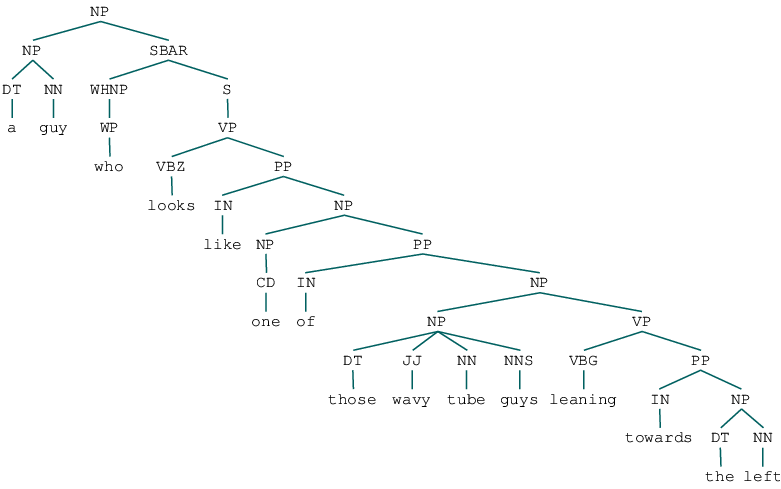

In [81]:
Tree.fromstring(predictor.predict_json({"sentence" : "a guy who looks like one of those wavy tube guys leaning towards the left"})['trees'])

In [43]:
from IPython.display import clear_output

tiny_d = d[['gameid', 'repetitionNum', 'contents', 'intendedName']]
parses = []
for i, s in enumerate(tiny_d['contents']) :
    clear_output(wait=True)
    print(i, '/', len(tiny_d['contents']))
    parses.append(predictor.predict_json({'sentence' : s})['hierplane_tree']['root'])
tiny_d['tree_parse'] = parses

6109 / 6110


/Users/rxdh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [44]:
def finditem(obj, value, initLevel = True):
    if obj['nodeType'] == value and not initLevel:
        return True
    elif 'children' in obj :
        for child in obj['children'] :
            item = finditem(child, value, initLevel = False)
            if item is not None:
                return item
tiny_d['SBAR'] = [finditem(s, 'SBAR') for s in tiny_d['tree_parse']]
tiny_d['PP'] = [finditem(s, 'PP') for s in tiny_d['tree_parse']]
tiny_d['CC'] = [finditem(s, 'CC') for s in tiny_d['tree_parse']]
tiny_d['NP'] = [finditem(s, 'NP') for s in tiny_d['tree_parse']]

/Users/rxdh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/rxdh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/rxdh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [45]:
tiny_d.to_json('./outputs/constituency_parses.json')
tiny_d.drop('tree_parse', 1).to_csv('./outputs/constituency_tags.csv')

In [46]:
tiny_d = pd.read_json('./outputs/constituency_parses.json')

In [58]:
gameids = np.unique(tiny_d['gameid'])
tangramids = np.unique(tiny_d['intendedName'])

transitions = np.zeros([len(gameids), len(tangramids) ,5])
for i, gameid in enumerate(gameids) :
    clear_output(wait=True)
    print(i, '/', len(gameids))
    game_d = tiny_d.query('gameid == "{0}"'.format(gameid))
    for j, intendedName in enumerate(tangramids) :
        for k, init_occurrenceNum in enumerate(range(1,6)) :
            dist = []
            sub1 = game_d.query('intendedName == "{0}" and repetitionNum == {1}'.format(intendedName, init_occurrenceNum))['tree_parse']
            sub2 = game_d.query('intendedName == "{0}" and repetitionNum == {1}'.format(
                intendedName, init_occurrenceNum+1
            ))['tree_parse']
            for tree1 in sub1 :
                for tree2 in sub2 :
                    dist.append(edit_distance(tree1, tree2))
            transitions[i, j, k] = np.max(dist) if dist else np.nan

84 / 85


TODO: normalized by tree size
TODO: maybe can show this more straightforward by doing permutation test thing on POS tags instead of words

In [59]:
np.nanmean(transitions, axis=0)

array([[26.04878049, 14.14492754,  8.90322581,  5.03333333,  3.82142857],
       [32.39506173, 19.        , 12.67164179,  8.75757576,  6.58730159],
       [17.92957746,  7.703125  ,  4.77192982,  2.32142857,  2.25925926],
       [23.31325301, 12.5       ,  8.89552239,  4.03125   ,  3.19354839],
       [19.45333333,  9.84057971,  5.328125  ,  3.        ,  1.98214286],
       [19.46987952, 13.31168831,  6.64473684,  5.        ,  2.95774648],
       [33.05063291, 21.13513514, 10.89552239,  7.02985075,  5.76190476],
       [26.93975904, 12.44303797,  6.36486486,  4.43661972,  3.73134328],
       [25.        , 13.98666667,  8.84848485,  6.33333333,  4.16071429],
       [26.02409639, 14.91025641,  7.43243243,  4.54285714,  3.43478261],
       [31.90361446, 17.74074074, 12.24358974,  7.64935065,  7.22535211],
       [23.54878049, 15.30769231,  9.80519481,  6.72      ,  4.51388889]])

### Across-game version
Instead of looking at edit distance from round $i$ to $i + 1$ for pair $j$, we look at average edit distances between pairs $j$ to $j+1$ on round $i$.

In [60]:
import random
print(random.sample([1,2], len([1,2])))

[2, 1]


In [61]:
acrossgame = np.zeros([len(tangramids),6, len(gameids)])
shuffled_gameids = random.sample(list(gameids), len(gameids))
for i, intendedName in enumerate(tangramids) :
    clear_output(wait=True)
    print(i, '/', len(tangramids))
    for repetitionNum in range(1,7) :
        mini_d = tiny_d.query('intendedName == "{0}" and repetitionNum == {1}'.format(intendedName, repetitionNum))      
        for k in range(len(gameids) -1) :
            dist = []
#            print(gameids[k], 'to', gameids[k+1])
            sub1 = mini_d.query('gameid == "{0}"'.format(gameids[k]))['tree_parse']
            sub2 = mini_d.query('gameid == "{0}"'.format(gameids[k+1]))['tree_parse']
            for tree1 in sub1 :
                for tree2 in sub2 :
                    dist.append(edit_distance(tree1, tree2))
#             print(sub1)
#             print(sub2)
            acrossgame[i, repetitionNum-1, k] = np.max(dist) if dist else np.nan

11 / 12


In [62]:
np.nanmean(acrossgame, axis=2)

array([[35.89411765, 22.01265823, 18.07017544, 11.91111111, 11.        ,
        10.18918919],
       [40.97647059, 27.67532468, 20.2238806 , 14.43636364, 13.42105263,
        10.95918367],
       [24.05      , 13.85245902, 11.9375    ,  7.64705882,  6.48571429,
         7.        ],
       [30.27710843, 19.46987952, 15.47540984, 10.45283019,  9.33333333,
         8.93617021],
       [26.1625    , 17.85294118, 11.7       ,  7.66037736,  6.35416667,
         5.73170732],
       [27.75294118, 19.59259259, 13.22972973, 12.46376812,  9.64516129,
         9.28333333],
       [39.5       , 28.62337662, 18.86153846, 14.875     , 12.98113208,
        10.86      ],
       [36.38554217, 21.48192771, 14.47945205, 11.296875  , 10.25862069,
         8.53703704],
       [32.92771084, 21.58227848, 15.        , 11.40816327, 11.95454545,
        10.02777778],
       [32.11111111, 22.84337349, 14.97183099, 13.23529412,  9.84210526,
         9.0862069 ],
       [41.49411765, 26.32098765, 20.93670886, 14.

# Calculate indicator words for tangrams/rounds

## First, get list of words in first round

In [51]:
# Filter down to first round
d_round1 = d[d['repetitionNum'] == 1]

# Pull out all tokens and collapse into count dict
tokenDict = Counter([item for sublist in d_round1['tokens'].tolist()
                     for item in sublist])
# Pull out all words that occur more than once
wordList = [word for (word,count) in tokenDict.items() if count > 1 and not word.isdigit()]
print(wordList[0:10])
print(len(wordList))

# Get POS map; will be longer because it doesn't require count > 1, but it doesn't matter
POSdict = {word.text: word.pos_ for text in d_round1['text'] for word in text}
print(len(POSdict.keys()))

['looking', 'for', 'a', 'diamond', 'at', 'the', 'top', 'triangle', 'pointing', 'towards']
595
1082


## Helper functions to select words & counts

In [59]:
def getWordCounts(df, gameid, occurrenceNum, tangram = None) :
    roundCond = 'repetitionNum == ' + occurrenceNum
    gameidCond = 'gameid == "' + gameid + '"'
    if(tangram is not None) :
        tangramCond = 'intendedName == "' + tangram + '"'
        cond = " and ".join((roundCond, gameidCond, tangramCond))
    else :
        cond = " and ".join((roundCond, gameidCond))
    relevantRow = df.query(cond)
    return Counter([item for sublist in relevantRow['tokens'].tolist() 
                    for item in sublist])

#creates mini dataframe that grabs the words used in round n for a given tangram and gameid
def selectTangramRoundWords(df, tangram, roundNum, gameid):
    wordCounts = getWordCounts(df, gameid, roundNum, tangram)
    return list(wordCounts.keys())